# DATA EXPLORATION

In this notebook I will explore and see how the data is built. My goal is try to undestand the evolution of the data I'm working with, and make some hypothessis about what should I do next.

### Imports

In [1]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns

# Machine Learning Models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

# Metrics and Evaluation
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, explained_variance_score, r2_score,
    mean_poisson_deviance, mean_gamma_deviance, accuracy_score
)

# Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose


# File Handling
import os

# Math
import math

# Time series models
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from tensorflow.keras.regularizers import l2
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Statistics
from scipy.stats import f_oneway

# Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Conv1D, MaxPooling1D, Flatten, Dropout

2024-04-07 19:52:57.839395: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-07 19:52:57.873205: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 19:52:57.873253: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 19:52:57.873273: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-07 19:52:57.880058: I tensorflow/core/platform/cpu_feature_g

### Dataset Class

The idea if this class is to group every function I need to work with the dataset. This way I would have everything I need in the same place.

In [2]:
class Dataset(object):
    def __init__(self, dataset, name):
        if not isinstance(dataset, pd.DataFrame):
            raise ValueError("Input 'dataset' must be a pandas DataFrame.")
        
        self.dataset = dataset.copy()

        self.name = name
        
        self.dataset['Date'] = pd.to_datetime(self.dataset['Date'])
        self.dataset.set_index('Date', inplace=True)        
        
    def __str__(self):
        return self.name
    
    def reset_train_test(self, train_ratio=0.7):
        if 0 < train_ratio < 1:
            training_size = int(len(self.dataset) * train_ratio)

            self.train = self.dataset.iloc[:training_size]
            self.test = self.dataset.iloc[training_size:]

            print("Train ratio: {}".format(train_ratio))
            print("Test ratio: {}".format(1-train_ratio))
        
        else:
            print("Please, train ratio between 0 and 1")
            
    def split_data(self, feature_columns, target_column, train_ratio=0.7):
        training_size = int(len(self.dataset) * train_ratio)
        self.train = self.dataset.iloc[:training_size]
        self.test = self.dataset.iloc[training_size:]
        X_train = self.train[feature_columns]
        Y_train = self.train[target_column]

        X_test = self.test[feature_columns]
        Y_test = self.test[target_column]

        return X_train, Y_train, X_test, Y_test
    
    def plot_candle(self):
        mpf.plot(self.dataset, type='candle', volume=True, style='yahoo', figsize=(10,6))
    
    def plot_heatmap(self):    
        plt.figure(figsize=(10,5))

        correlation = self.dataset.corr()
        sns.heatmap(correlation, annot=True)

        plt.show()
        
    def show_nulls(self):
        return self.dataset.isna().sum()

### Model Class

In [3]:
class Model(object):
    def __init__(self, model):
        self.model = model  
        
    def fit(self):
        return self.model.fit()
    
    def predict(self, Dataset, feature_columns, target_column):
        X_train, y_train, X_test, y_test = Dataset.split_data(feature_columns, target_column)

        # Initialize the Random Forest Regressor model
        my_model = self.model
        my_model.fit(X_train, y_train)

        test_predict = my_model.predict(X_test)
        
        mae = mean_absolute_error(y_test, test_predict)
        rmse = math.sqrt(mean_squared_error(y_test, test_predict))

        print("-"*100)
        print("Mean Absolute Error - MAE : " + str(mae))
        print("Root Mean squared Error - RMSE : " + str(rmse))
        print("-"*100)

        test_predict = test_predict.reshape(-1,1)

        return test_predict, mae, rmse
    
    def print_accuracy(self, Dataset, predicted_values):
        mae = mean_absolute_error(Dataset.test['close'].values, predicted_values)

        percentage_accuracy = 100 - (mae / Dataset.test.values.mean()) * 100
        
        print("The accuracy of the model is {}%".format(percentage_accuracy))
    
    def plot_predictions(self, Dataset, test_predict):
        test_predict = test_predict.reshape(-1,1)
        train_shape = Dataset.train.shape[0]

        # Your original code for plotting the black and red lines
        fig, ax = plt.subplots(figsize=(15, 6))
        sns.lineplot(x=Dataset.dataset.index[:train_shape+1], y=Dataset.dataset['Close'][:train_shape+1], color='black')
        sns.lineplot(x=Dataset.dataset.index[train_shape:], y=Dataset.dataset['Close'][train_shape:], color='red')

        # Plot the test data on top of the red line
        sns.lineplot(x=Dataset.dataset.index[train_shape:], y=test_predict[:, 0], color='blue')

        # Formatting
        ax.set_title('Value Evolution', fontsize=20, loc='center', fontdict=dict(weight='bold'))
        ax.set_xlabel('Date', fontsize=16, fontdict=dict(weight='bold'))
        ax.set_ylabel('Daily Sales', fontsize=16, fontdict=dict(weight='bold'))
        plt.tick_params(axis='y', which='major', labelsize=16)
        plt.tick_params(axis='x', which='major', labelsize=16)

        # Customize legend labels and colors
        plt.legend(loc='upper right', labels=['train', 'test', 'predicted test'], 
                   handles=[plt.Line2D([0], [0], color='black', label='train'),
                            plt.Line2D([0], [0], color='red', label='test'),
                            plt.Line2D([0], [0], color='blue', label='predicted test')])

        plt.show()

### Download the data

Here I create the datasets using my class.

In [4]:
AMAZON = Dataset(pd.read_csv('AMAZON/AMZN.csv'), 'Amazon')
APPLE = Dataset(pd.read_csv('APPLE/APLE.csv'), 'Apple')
NETFLIX = Dataset(pd.read_csv('NETFLIX/NFLX.csv'), 'Netflix')
SPX500 = Dataset(pd.read_csv('SPX500/SPX.csv'), 'SPX500')

### Analysing data

Let's have a look at the datasets:

In [5]:
AMAZON.dataset

Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-03-06   95.190002   96.550003   93.739998   93.750000   93.750000   
2023-03-07   94.059998   95.089996   92.779999   93.550003   93.550003   
2023-03-08   93.599998   94.169998   92.180000   93.919998   93.919998   
2023-03-09   93.680000   96.209999   92.180000   92.250000   92.250000   
2023-03-10   92.669998   93.570000   90.250000   90.730003   90.730003   
...                ...         ...         ...         ...         ...   
2024-02-28  172.440002  174.050003  172.270004  173.160004  173.160004   
2024-02-29  173.009995  177.220001  172.850006  176.759995  176.759995   
2024-03-01  176.750000  178.729996  176.070007  178.220001  178.220001   
2024-03-04  177.529999  180.139999  177.490005  177.580002  177.580002   
2024-03-05  176.929993  176.929993  173.300003  174.119995  174.119995   

              Volume  
Date                  
2023-03-06  52112400  
2023-03-07  49100700  
2023-03-08  44899100  
2023-03-09  56218700  
2023-03-10  69827500  
...              ...  
2024-02-28  28180500  
2024-02-29  53805400  
2024-03-01  31956200  
2024-03-04  37381500  
2024-03-05  37163200  

[252 rows x 6 columns]

In [6]:
APPLE.dataset

Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2023-01-03  15.970000  16.030001  15.380000  15.490000  14.375418  1335400
2023-01-04  15.720000  16.000000  15.630000  15.780000  14.644549  1394400
2023-01-05  15.740000  15.740000  15.330000  15.400000  14.291888  1378800
2023-01-06  15.450000  15.750000  15.450000  15.570000  14.449658  1232600
2023-01-09  15.540000  15.690000  15.520000  15.620000  14.496060  1308800
...               ...        ...        ...        ...        ...      ...
2024-02-28  15.810000  16.264999  15.790000  16.059999  16.059999  2470600
2024-02-29  16.209999  16.270000  15.980000  16.090000  16.090000  2854900
2024-03-01  16.180000  16.430000  16.110001  16.340000  16.340000  1889900
2024-03-04  16.280001  16.700001  16.270000  16.680000  16.680000  2642300
2024-03-05  16.549999  16.700001  16.450001  16.459999  16.459999  1441300

[294 rows x 6 columns]

In [7]:
NETFLIX.dataset

Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-03  298.059998  298.390015  288.700012  294.950012  294.950012   
2023-01-04  298.239990  311.140015  295.510010  309.410004  309.410004   
2023-01-05  307.000000  314.179993  304.549988  309.700012  309.700012   
2023-01-06  311.570007  316.769989  303.690002  315.549988  315.549988   
2023-01-09  316.829987  321.700012  313.220001  315.170013  315.170013   
...                ...         ...         ...         ...         ...   
2024-02-28  595.789978  598.169983  590.010010  596.479980  596.479980   
2024-02-29  604.250000  604.520020  595.159973  602.919983  602.919983   
2024-03-01  599.809998  620.280029  599.500000  619.340027  619.340027   
2024-03-04  621.559998  624.419983  615.080017  615.830017  615.830017   
2024-03-05  610.099976  610.909973  592.000000  598.500000  598.500000   

             Volume  
Date                 
2023-01-03  6764000  
2023-01-04  9345100  
2023-01-05  8328400  
2023-01-06  8959800  
2023-01-09  6766600  
...             ...  
2024-02-28  2605200  
2024-02-29  3572100  
2024-03-01  4264200  
2024-03-04  3020300  
2024-03-05  3846900  

[294 rows x 6 columns]

In [8]:
SPX500.dataset

Open         High          Low        Close    Adj Close  \
Date                                                                          
2023-01-03  3853.290039  3878.459961  3794.330078  3824.139893  3824.139893   
2023-01-04  3840.360107  3873.159912  3815.770020  3852.969971  3852.969971   
2023-01-05  3839.739990  3839.739990  3802.419922  3808.100098  3808.100098   
2023-01-06  3823.370117  3906.189941  3809.560059  3895.080078  3895.080078   
2023-01-09  3910.820068  3950.570068  3890.419922  3892.090088  3892.090088   
...                 ...          ...          ...          ...          ...   
2024-02-28  5067.200195  5077.370117  5058.350098  5069.759766  5069.759766   
2024-02-29  5085.359863  5104.990234  5061.890137  5096.270020  5096.270020   
2024-03-01  5098.509766  5140.330078  5094.160156  5137.080078  5137.080078   
2024-03-04  5130.990234  5149.669922  5127.180176  5130.950195  5130.950195   
2024-03-05  5110.520020  5114.540039  5056.819824  5078.649902  5078.649902   

                Volume  
Date                    
2023-01-03  3959140000  
2023-01-04  4414080000  
2023-01-05  3893450000  
2023-01-06  3923560000  
2023-01-09  4311770000  
...                ...  
2024-02-28  3789370000  
2024-02-29  5219740000  
2024-03-01  4748110000  
2024-03-04  4758440000  
2024-03-05  4418410000  

[294 rows x 6 columns]

Let's look for NaN values, if there're any.

In [9]:
AMAZON.dataset.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
APPLE.dataset.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
NETFLIX.dataset.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [12]:
SPX500.dataset.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

There are no NaN values from any datasets.

### PLOTTING DATASETS

For further investigations, let's have a look at how the data is displayed

The first I going to plot is AMAZON.

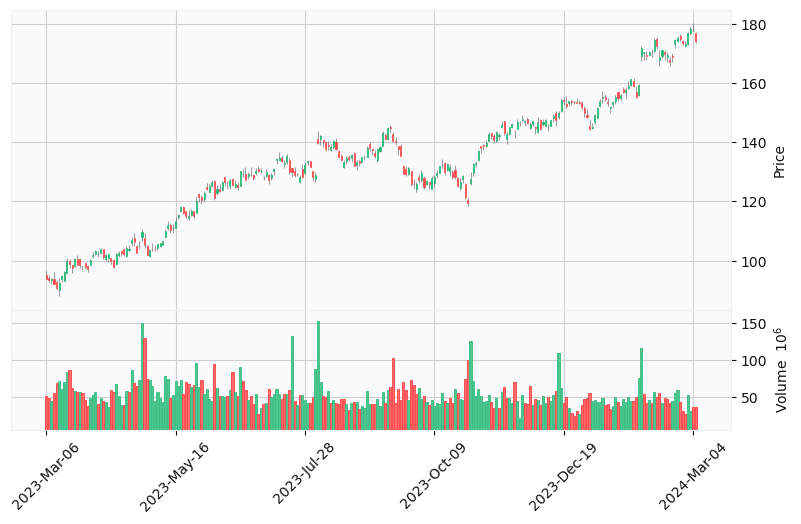

In [13]:
AMAZON.plot_candle()

I can see 3 different time gaps, but the tendency stills positive.

Now I'm gonna have a look at the APPLE stock market.

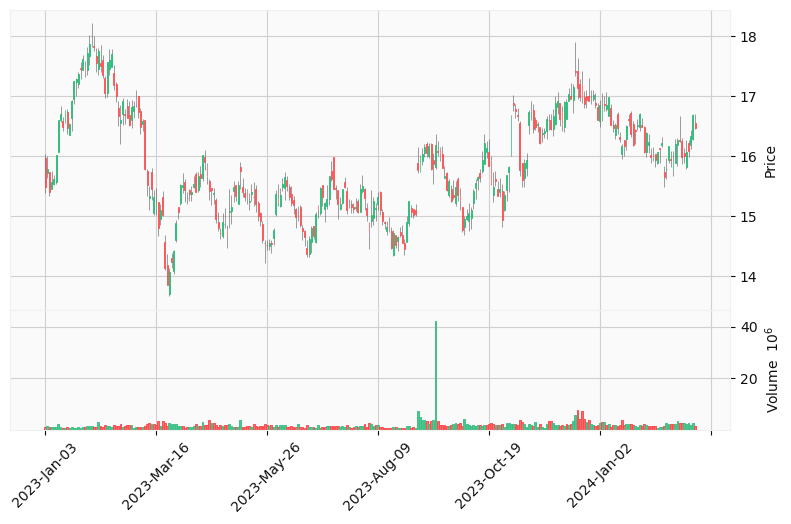

In [14]:
APPLE.plot_candle()

I can see a huge WYCKOFF structure that goes from March 2023 to October 2023. There are many oscillations, and its not as clear as the last one if the tendency is positive or negative.

Now the NETFLIX dataset.

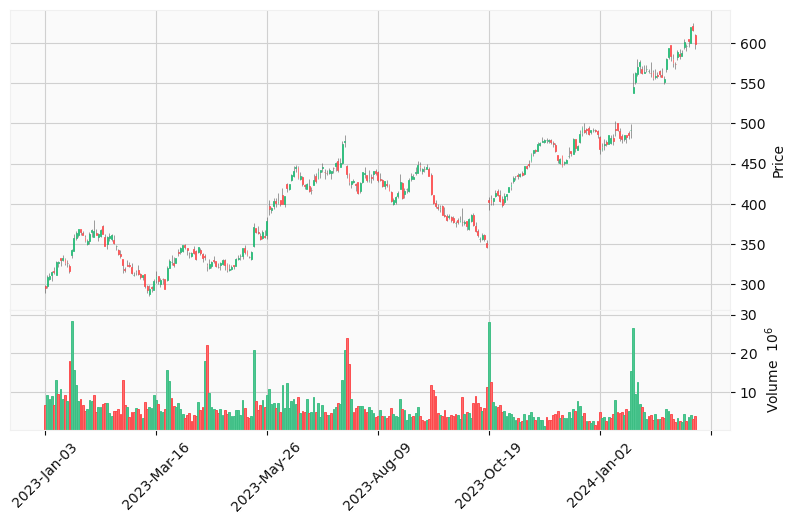

In [15]:
NETFLIX.plot_candle()

I can see a positive tendency, and a WYCKOFF Structure from May 2023 to October 2023. The tendency is still positive.

The last dataset I am going to plot is the SPX-500 index.

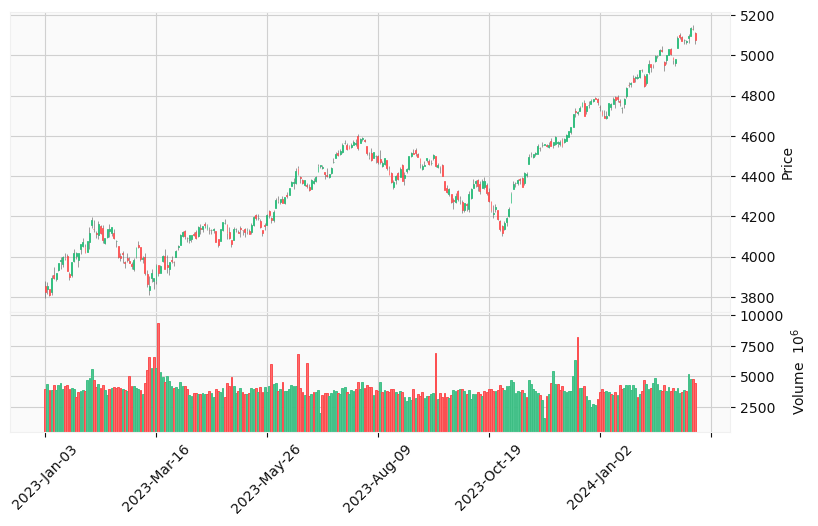

In [16]:
SPX500.plot_candle()

The tendency is still positive, and I can find a WYCKOFF structure from April 2023 to September 2023

### Studying the correlation

Let's have a look at the correlation using the `plot_heatmap()` function.

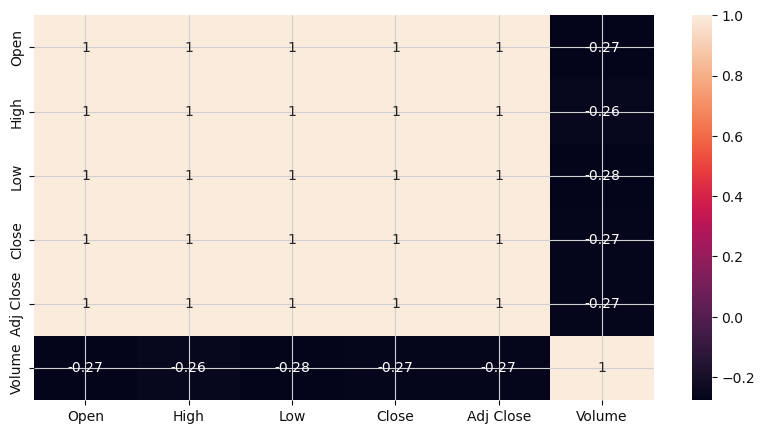

In [17]:
AMAZON.plot_heatmap()

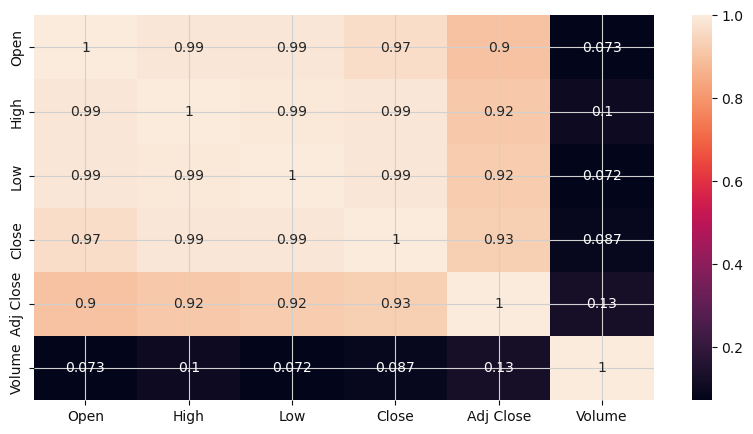

In [18]:
APPLE.plot_heatmap()

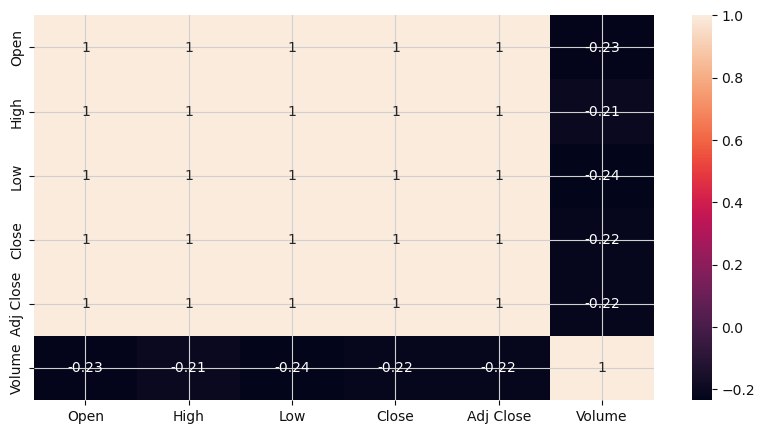

In [19]:
NETFLIX.plot_heatmap()

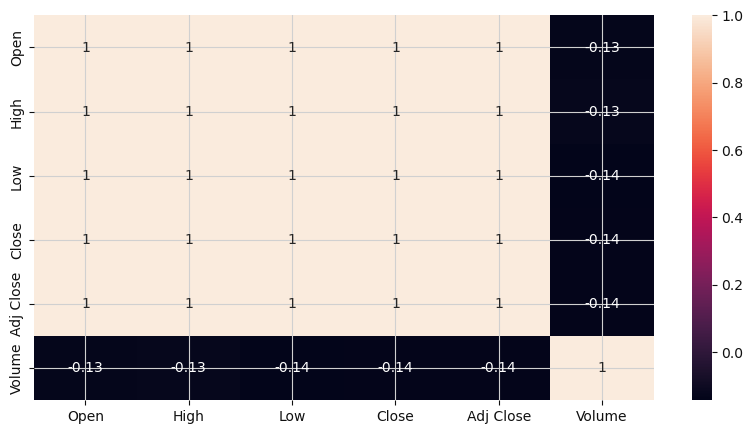

In [20]:
SPX500.plot_heatmap()

### Studying features

I have no interesest in the Ajusted Close value, so I will delete that feature. Even though the volume has no correlation between the other variables, I know for sure is very important to understand how the values changes though time, so this one can not be deleted at any cost. The other values will help me to understand the context of the time frame.

In [21]:
AMAZON.dataset.drop(columns=['Adj Close'], inplace=True)
APPLE.dataset.drop(columns=['Adj Close'], inplace=True)
NETFLIX.dataset.drop(columns=['Adj Close'], inplace=True)
SPX500.dataset.drop(columns=['Adj Close'], inplace=True)

In [22]:
AMAZON.dataset

Open        High         Low       Close    Volume
Date                                                                
2023-03-06   95.190002   96.550003   93.739998   93.750000  52112400
2023-03-07   94.059998   95.089996   92.779999   93.550003  49100700
2023-03-08   93.599998   94.169998   92.180000   93.919998  44899100
2023-03-09   93.680000   96.209999   92.180000   92.250000  56218700
2023-03-10   92.669998   93.570000   90.250000   90.730003  69827500
...                ...         ...         ...         ...       ...
2024-02-28  172.440002  174.050003  172.270004  173.160004  28180500
2024-02-29  173.009995  177.220001  172.850006  176.759995  53805400
2024-03-01  176.750000  178.729996  176.070007  178.220001  31956200
2024-03-04  177.529999  180.139999  177.490005  177.580002  37381500
2024-03-05  176.929993  176.929993  173.300003  174.119995  37163200

[252 rows x 5 columns]

In [23]:
APPLE.dataset

Open       High        Low      Close   Volume
Date                                                           
2023-01-03  15.970000  16.030001  15.380000  15.490000  1335400
2023-01-04  15.720000  16.000000  15.630000  15.780000  1394400
2023-01-05  15.740000  15.740000  15.330000  15.400000  1378800
2023-01-06  15.450000  15.750000  15.450000  15.570000  1232600
2023-01-09  15.540000  15.690000  15.520000  15.620000  1308800
...               ...        ...        ...        ...      ...
2024-02-28  15.810000  16.264999  15.790000  16.059999  2470600
2024-02-29  16.209999  16.270000  15.980000  16.090000  2854900
2024-03-01  16.180000  16.430000  16.110001  16.340000  1889900
2024-03-04  16.280001  16.700001  16.270000  16.680000  2642300
2024-03-05  16.549999  16.700001  16.450001  16.459999  1441300

[294 rows x 5 columns]

In [24]:
NETFLIX.dataset

Open        High         Low       Close   Volume
Date                                                               
2023-01-03  298.059998  298.390015  288.700012  294.950012  6764000
2023-01-04  298.239990  311.140015  295.510010  309.410004  9345100
2023-01-05  307.000000  314.179993  304.549988  309.700012  8328400
2023-01-06  311.570007  316.769989  303.690002  315.549988  8959800
2023-01-09  316.829987  321.700012  313.220001  315.170013  6766600
...                ...         ...         ...         ...      ...
2024-02-28  595.789978  598.169983  590.010010  596.479980  2605200
2024-02-29  604.250000  604.520020  595.159973  602.919983  3572100
2024-03-01  599.809998  620.280029  599.500000  619.340027  4264200
2024-03-04  621.559998  624.419983  615.080017  615.830017  3020300
2024-03-05  610.099976  610.909973  592.000000  598.500000  3846900

[294 rows x 5 columns]

In [25]:
SPX500.dataset

Open         High          Low        Close      Volume
Date                                                                      
2023-01-03  3853.290039  3878.459961  3794.330078  3824.139893  3959140000
2023-01-04  3840.360107  3873.159912  3815.770020  3852.969971  4414080000
2023-01-05  3839.739990  3839.739990  3802.419922  3808.100098  3893450000
2023-01-06  3823.370117  3906.189941  3809.560059  3895.080078  3923560000
2023-01-09  3910.820068  3950.570068  3890.419922  3892.090088  4311770000
...                 ...          ...          ...          ...         ...
2024-02-28  5067.200195  5077.370117  5058.350098  5069.759766  3789370000
2024-02-29  5085.359863  5104.990234  5061.890137  5096.270020  5219740000
2024-03-01  5098.509766  5140.330078  5094.160156  5137.080078  4748110000
2024-03-04  5130.990234  5149.669922  5127.180176  5130.950195  4758440000
2024-03-05  5110.520020  5114.540039  5056.819824  5078.649902  4418410000

[294 rows x 5 columns]

# PREDICTIONS

For the predictions, we are going to try up differents models and compare each one of them thought the accuracy on the test set and the mse or rmse of those predictions.

In [26]:
def run_regression_models(models, datasets, features, target):
    for dataset_name, dataset in datasets.items():
        print('='*50)
        print(f"USING {dataset_name} DATASET")
        print("="*50)

        mae_values = []
        rmse_values = []
        feature_importances = {}  # Emagatzema la importància de les característiques per a cada model

        for model_name, model in models.items():
            model_class = Model(model)

            print(f"Training and evaluating {model_name}...")
            test_predict, mae, rmse = model_class.predict(dataset, features, target)
            model_class.plot_predictions(dataset, test_predict)

            # Append MAE and RMSE values to lists
            mae_values.append(mae)
            rmse_values.append(rmse)
            
            # Calcular la importància de les característiques si el model ho permet
            if hasattr(model, 'feature_importances_'):
                feature_importances[model_name] = model.feature_importances_
            elif hasattr(model, 'coef_'):
                feature_importances[model_name] = np.abs(model.coef_)
            else:
                feature_importances[model_name] = None

        # Plot MAE and RMSE
        fig, ax = plt.subplots(figsize=(12, 6))
        index = np.arange(len(models))
        bar_width = 0.35

        bar1 = ax.bar(index, mae_values, bar_width, label='MAE', color='blue')
        bar2 = ax.bar(index + bar_width, rmse_values, bar_width, label='RMSE', color='green')

        ax.set_xlabel('Models')
        ax.set_ylabel('Error Values')
        ax.set_title('MAE and RMSE for Each Model')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(models.keys(), rotation=45)
        ax.legend()

        plt.tight_layout()
        plt.show()


        # Plot feature importance if available
        fig, ax2 = plt.subplots(figsize=(10, 6))
        index = np.arange(len(features))
        bar_width = 0.2  # Amplada de les barres
        colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow', 'pink', 'cyan', 'magenta']  # Colors per als models
        spacing = 0.1   # Espai entre les barres del mateix model
        added_labels = set()  # Conjunt per mantenir el seguiment dels noms de models afegits
        for i, feature in enumerate(features):
            for j, model_name in enumerate(models.keys()):
                importance = feature_importances[model_name][i]
                # Afegir el label només si no s'ha afegit prèviament
                if model_name not in added_labels:
                    ax2.bar(index[i] + (bar_width + spacing) * j, importance, bar_width, label=model_name, color=colors[j])
                    added_labels.add(model_name)  # Afegir el nom del model al conjunt de seguiment
                else:
                    ax2.bar(index[i] + (bar_width + spacing) * j, importance, bar_width, color=colors[j])
        ax2.set_title('Feature Importance for Each Model')
        ax2.set_xlabel('Features')
        ax2.set_ylabel('Importance')
        ax2.set_xticks(index)
        ax2.set_xticklabels(features, rotation=45)
        ax2.legend()

        plt.tight_layout()
        plt.show()




We are going to use a LSTM to make predictions using tensorflow. The model is as follows.

In [27]:
class MyLSTMModel:
    def __init__(self, input_shape, lstm_units=[512, 256, 128], dense_units=[25, 1]):
        self.model = self.build_model(input_shape, lstm_units, dense_units)

    def build_model(self, input_shape, lstm_units, dense_units):
        model = Sequential()
        #model.add(Conv1D(filters=64, kernel_size=3, kernel_regularizer=l2(0.001), activation='relu', 
        #                 input_shape=(input_shape, 1)))
        model.add(LSTM(lstm_units[0], return_sequences=False, input_shape=(input_shape, 1)))
        #model.add(MaxPooling1D(pool_size=2))
        #model.add(LSTM(lstm_units[1], return_sequences=True))
        #model.add(LSTM(lstm_units[2], return_sequences=True))
        
        #model.add(Dense(64, activation='relu'))
        #model.add(Dropout(0.5))
        #model.add(Dense(32, activation='relu'))
        
        #model.add(LSTM(lstm_units[0], return_sequences=True, kernel_regularizer=l2(0.001)))
        #model.add(LSTM(lstm_units[1], return_sequences=True))
        #model.add(LSTM(lstm_units[2], return_sequences=False))

        #model.add(Dense(dense_units[0]))
        model.add(Dense(dense_units[1]))

        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    def train(self, X_train, y_train, epochs=100, batch_size=32):
        print("[STATUS] Training...")
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    def evaluate(self, X_test, y_test):
        print("[STATUS] Evaluating...")
        return self.model.evaluate(X_test, y_test, verbose=0)
    
    def calculate_metrics(self, X_test, y_test, predictions):
        print("[STATUS] Calculating metrics...")
        # Obté les prediccions del model
        predictions = self.model.predict(X_test)
        # Calcula el MSE
        mse = np.mean(np.square(predictions - y_test))
        # Calcula el RMSE
        rmse = np.sqrt(mse)
        
        mae = np.mean(np.abs(predictions - y_test))
        
        return mae[0], rmse[0]

In [28]:

def run_lstm_model(datasets, features, target):
    mae_values = []
    rmse_values = []
    feature_importances = []

    for dataset_name, dataset in datasets.items():
        print("="*30)
        print(f"USING {dataset_name} DATASET")
        print("="*30)
        X_train, y_train, X_test, y_test = dataset.split_data(features, target)
        model = Model(MyLSTMModel(X_train.shape[1]))

        model.model.train(X_train, y_train)
        model.model.evaluate(X_test, y_test)

        predictions = model.model.model.predict(X_test)    
        model.plot_predictions(dataset, predictions)

        mae, rmse = model.model.calculate_metrics(X_test, y_test, predictions)
        mae_values.append(mae)
        rmse_values.append(rmse)

    # Plot de MAE i RMSE per a cada conjunt de dades
    fig, ax = plt.subplots(figsize=(12, 6))
    index = np.arange(len(datasets))
    bar_width = 0.35

    bar1 = ax.bar(index, mae_values, bar_width, label='MAE', color='blue')
    bar2 = ax.bar(index + bar_width, rmse_values, bar_width, label='RMSE', color='green')

    ax.set_xlabel('Datasets')
    ax.set_ylabel('Error Values')
    ax.set_title('MAE and RMSE for Each Dataset')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(datasets.keys(), rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()

### First approach

Simple strategies are going to be the first type of models I am going to try. I am going to try to predict the close value given the previous ones. I am going to generate another column, `next close`, which will have the next close value.

In [29]:
AMAZON2 = Dataset(pd.read_csv('AMAZON/AMZN.csv'), 'Amazon')
APPLE2 = Dataset(pd.read_csv('APPLE/APLE.csv'), 'Apple')
NETFLIX2 = Dataset(pd.read_csv('NETFLIX/NFLX.csv'), 'Netflix')
SPX5002 = Dataset(pd.read_csv('SPX500/SPX.csv'), 'Spx500')

AMAZON2.dataset.drop(columns=['Adj Close'], inplace=True)
AMAZON2.dataset['Next Close'] = AMAZON2.dataset['Close'].shift(-1)
AMAZON2.dataset = AMAZON2.dataset.iloc[:-1]

APPLE2.dataset.drop(columns=['Adj Close'], inplace=True)
APPLE2.dataset['Next Close'] = APPLE2.dataset['Close'].shift(-1)
APPLE2.dataset = APPLE2.dataset.iloc[:-1]

NETFLIX2.dataset.drop(columns=['Adj Close'], inplace=True)
NETFLIX2.dataset['Next Close'] = NETFLIX2.dataset['Close'].shift(-1)
NETFLIX2.dataset = NETFLIX2.dataset.iloc[:-1]


SPX5002.dataset.drop(columns=['Adj Close'], inplace=True)
SPX5002.dataset['Next Close'] = SPX5002.dataset['Close'].shift(-1)
SPX5002.dataset = SPX5002.dataset.iloc[:-1]

### Regression models

USING AMAZON DATASET
Training and evaluating Random Forest...


/home/marc/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 14.49475149429002
Root Mean squared Error - RMSE : 18.045893709309027
----------------------------------------------------------------------------------------------------


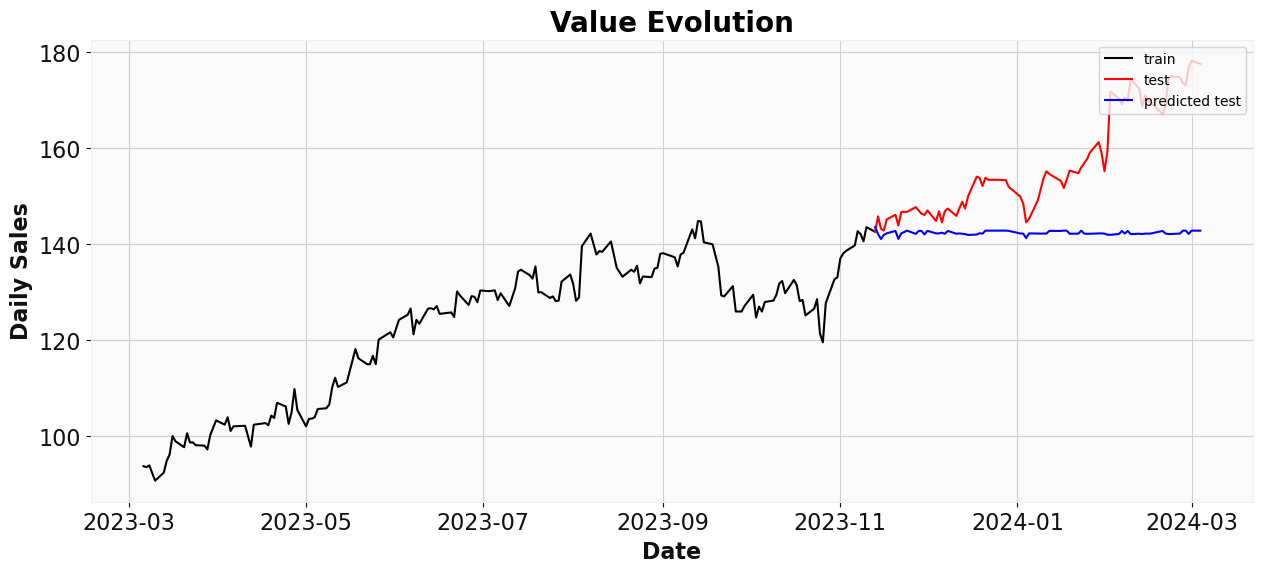

Training and evaluating Decision Tree...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 16.379868500000008
Root Mean squared Error - RMSE : 19.660641620781558
----------------------------------------------------------------------------------------------------


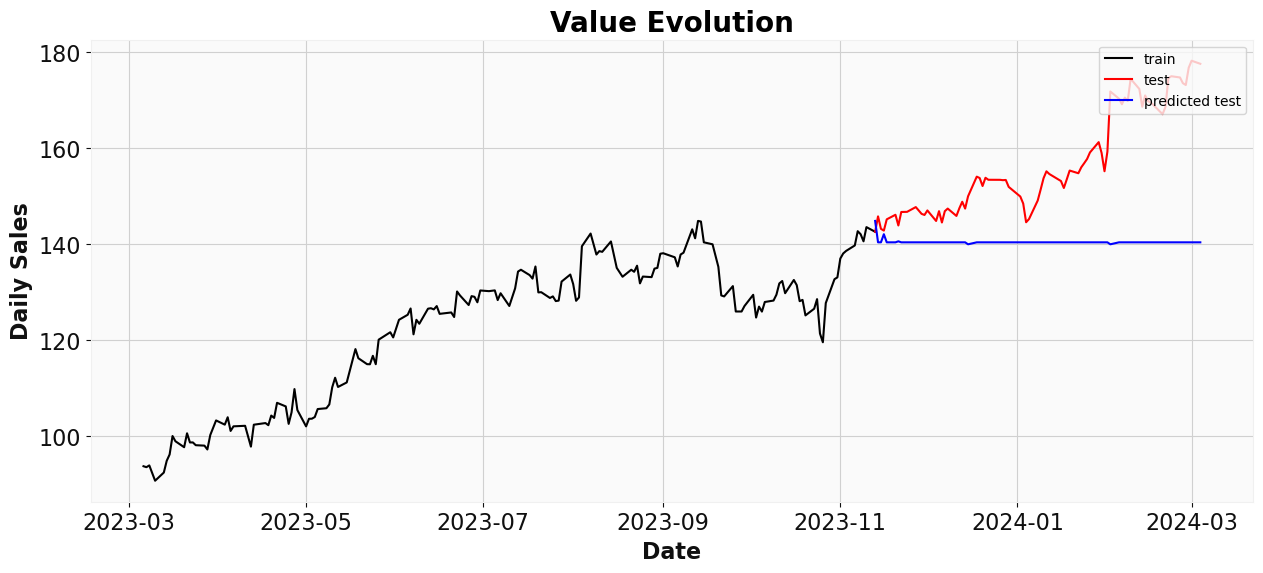

Training and evaluating XGBoost...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 15.92165754887952
Root Mean squared Error - RMSE : 19.307601281042455
----------------------------------------------------------------------------------------------------


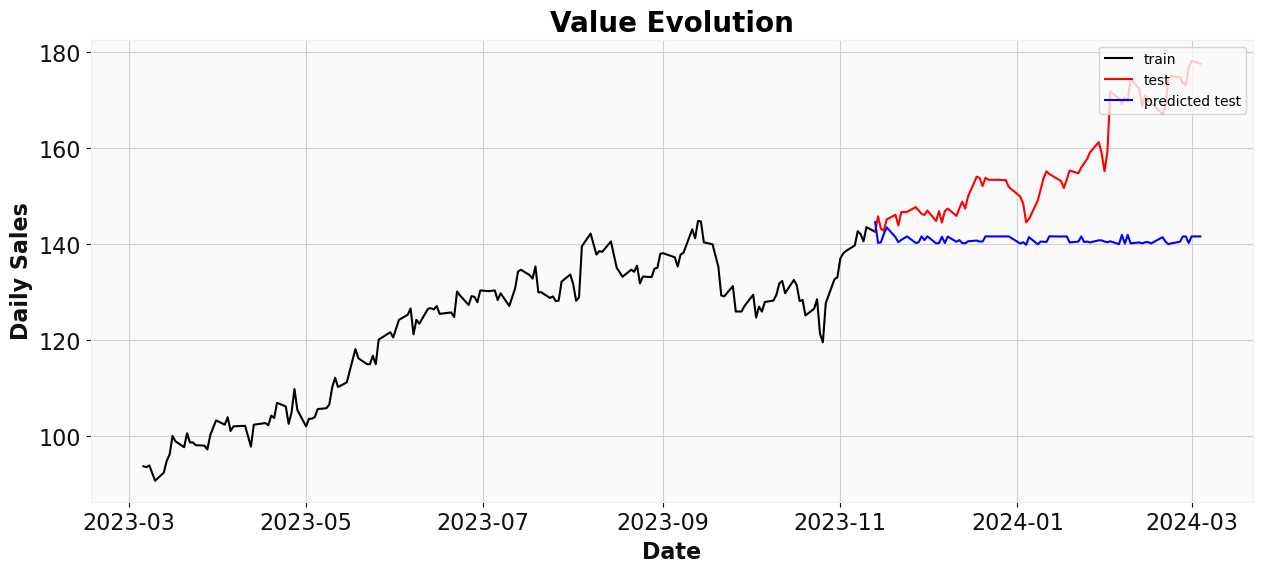

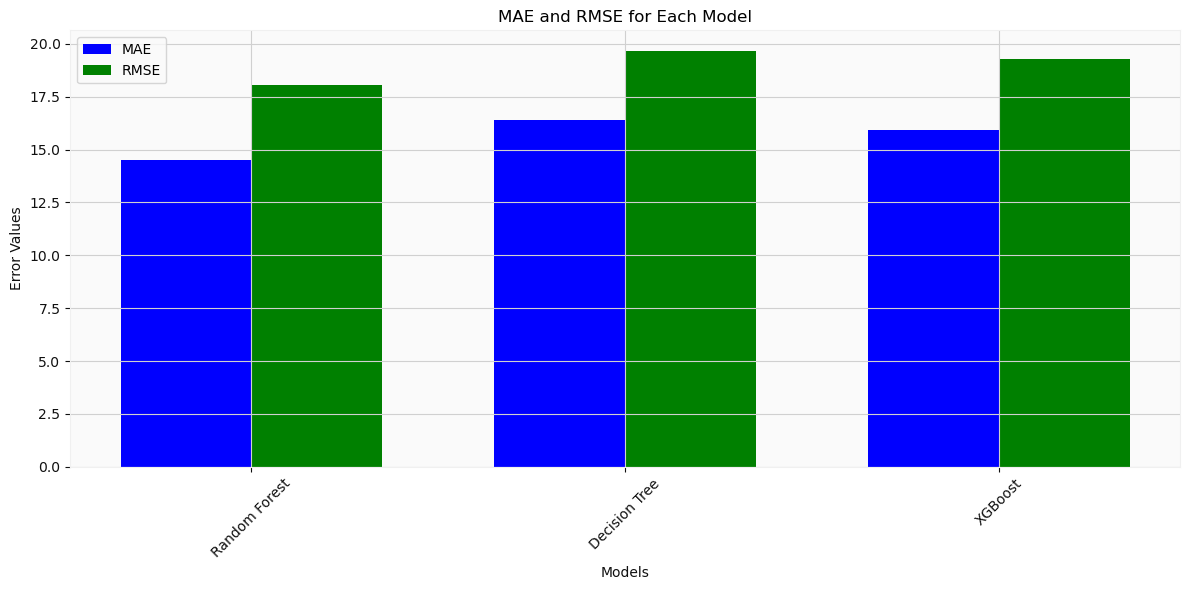

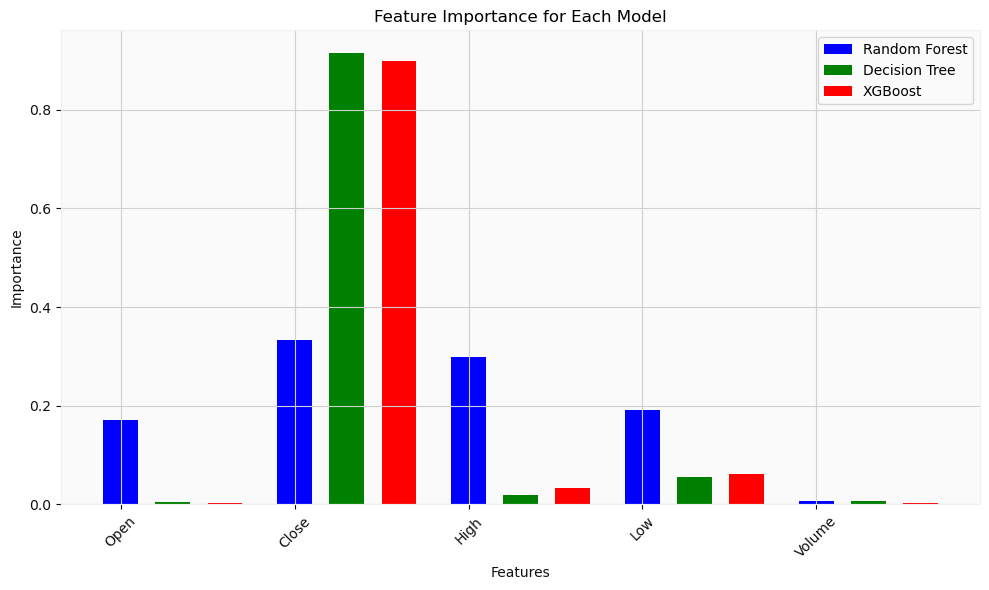

USING APPLE DATASET
Training and evaluating Random Forest...


/home/marc/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 0.22915704614771684
Root Mean squared Error - RMSE : 0.3029307361673259
----------------------------------------------------------------------------------------------------


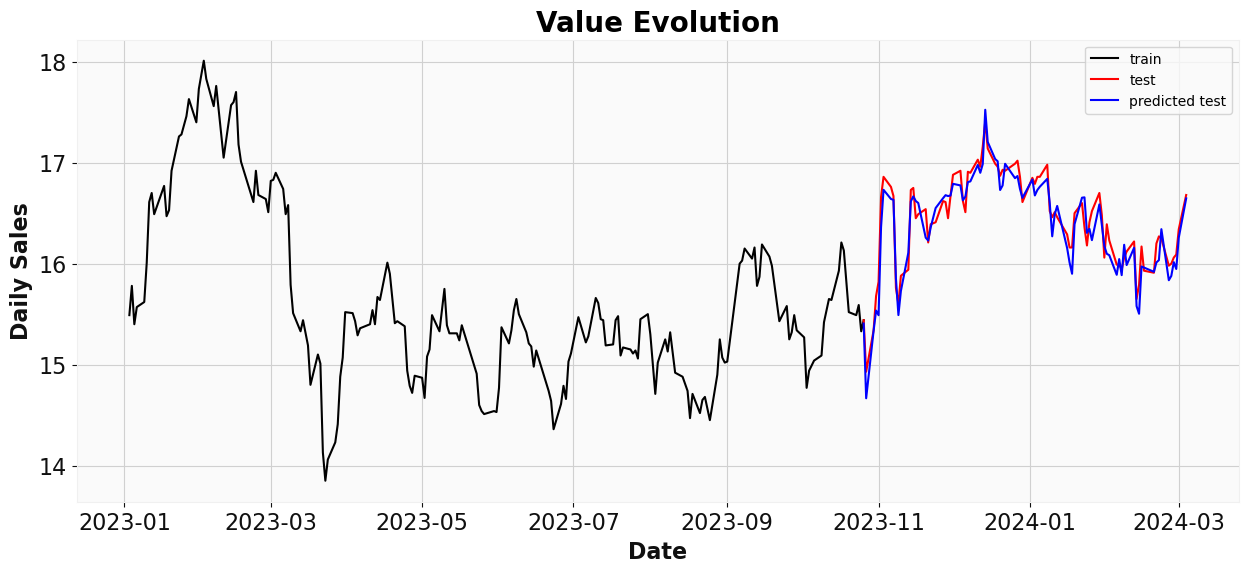

Training and evaluating Decision Tree...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 0.3360227159090913
Root Mean squared Error - RMSE : 0.4215434454053804
----------------------------------------------------------------------------------------------------


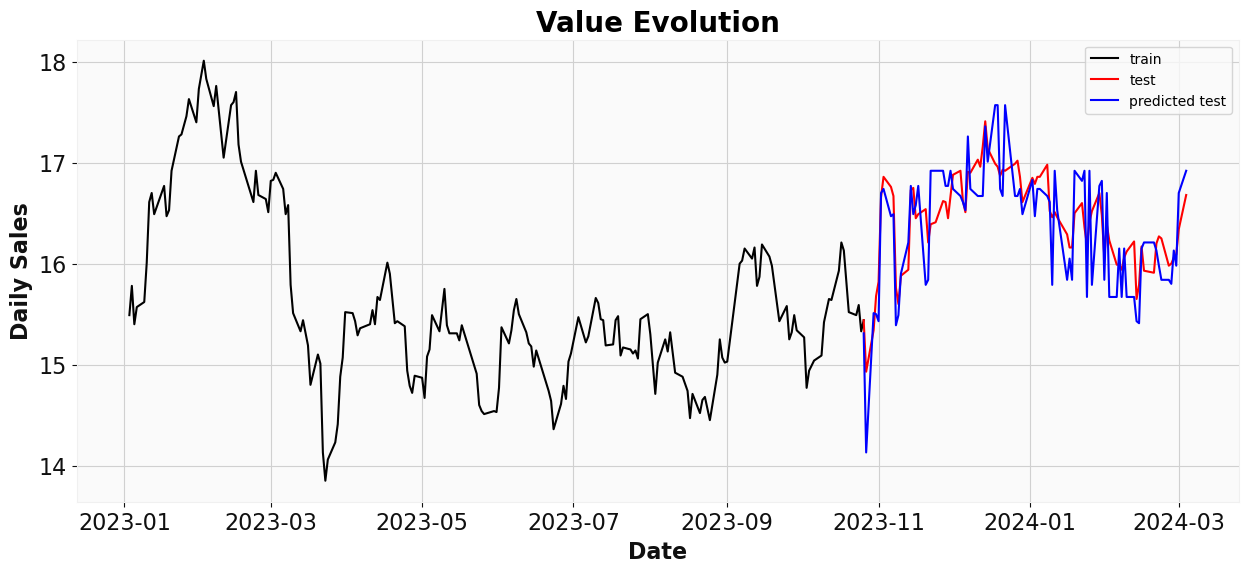

Training and evaluating XGBoost...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 0.2483937687377931
Root Mean squared Error - RMSE : 0.31370255865959945
----------------------------------------------------------------------------------------------------


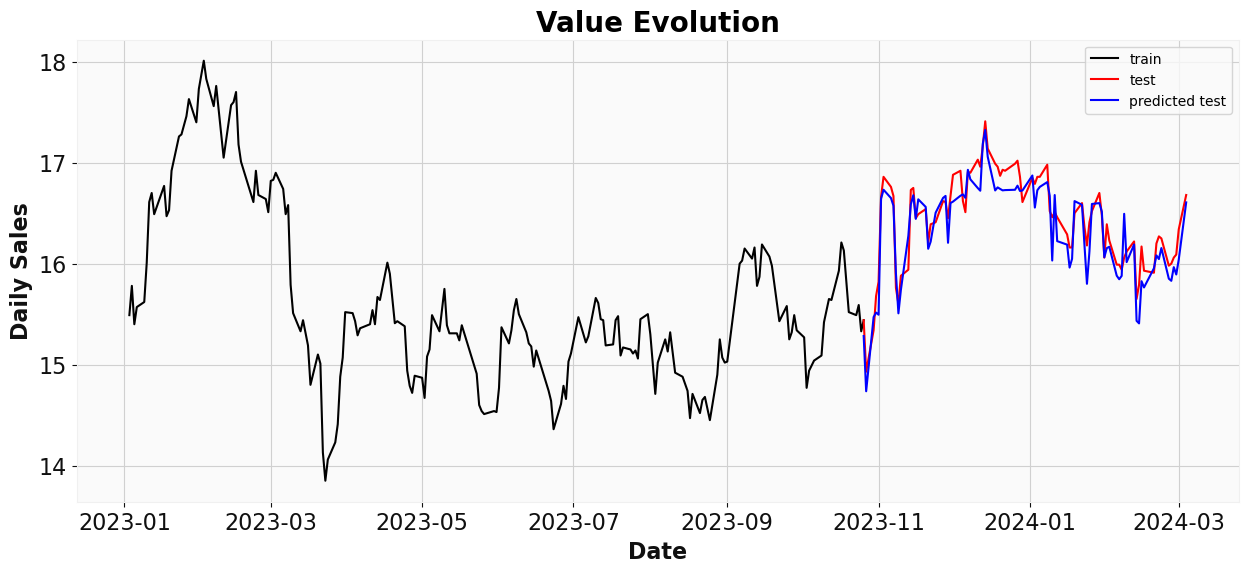

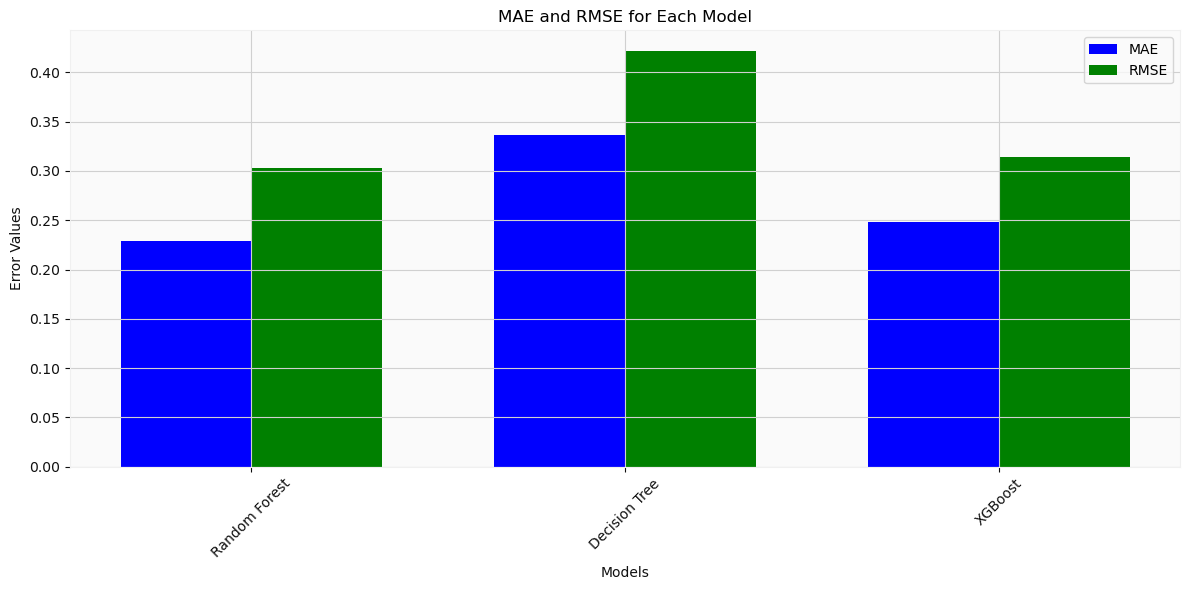

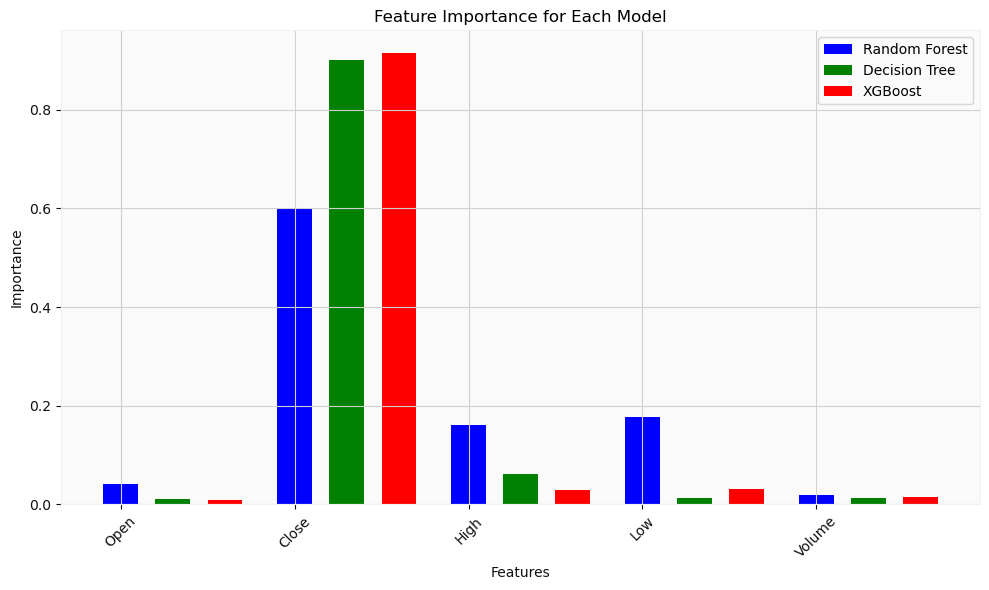

USING NETFLIX DATASET
Training and evaluating Random Forest...


/home/marc/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 53.11234374822382
Root Mean squared Error - RMSE : 73.82674601293122
----------------------------------------------------------------------------------------------------


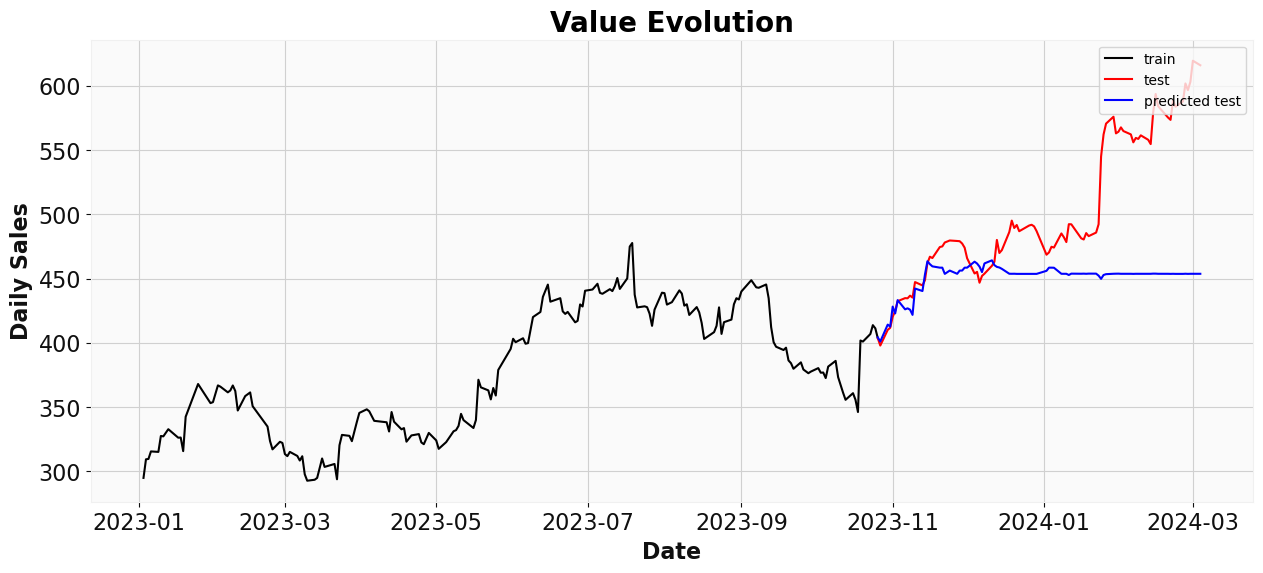

Training and evaluating Decision Tree...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 63.56533011363637
Root Mean squared Error - RMSE : 84.94875265866487
----------------------------------------------------------------------------------------------------


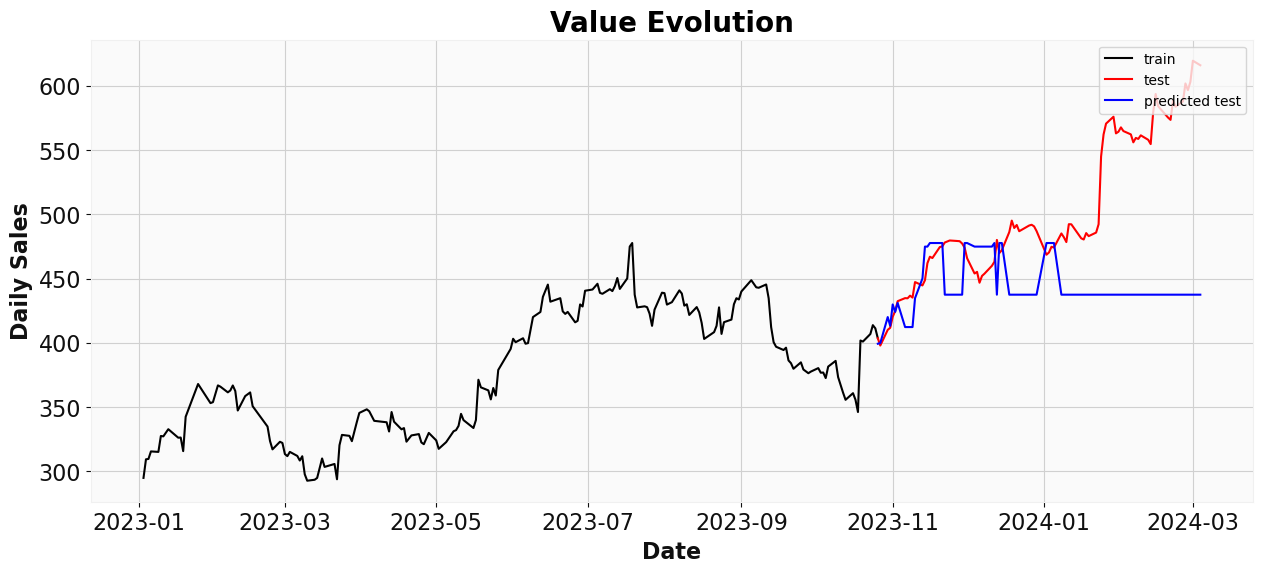

Training and evaluating XGBoost...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 65.04804199116656
Root Mean squared Error - RMSE : 85.1396703541086
----------------------------------------------------------------------------------------------------


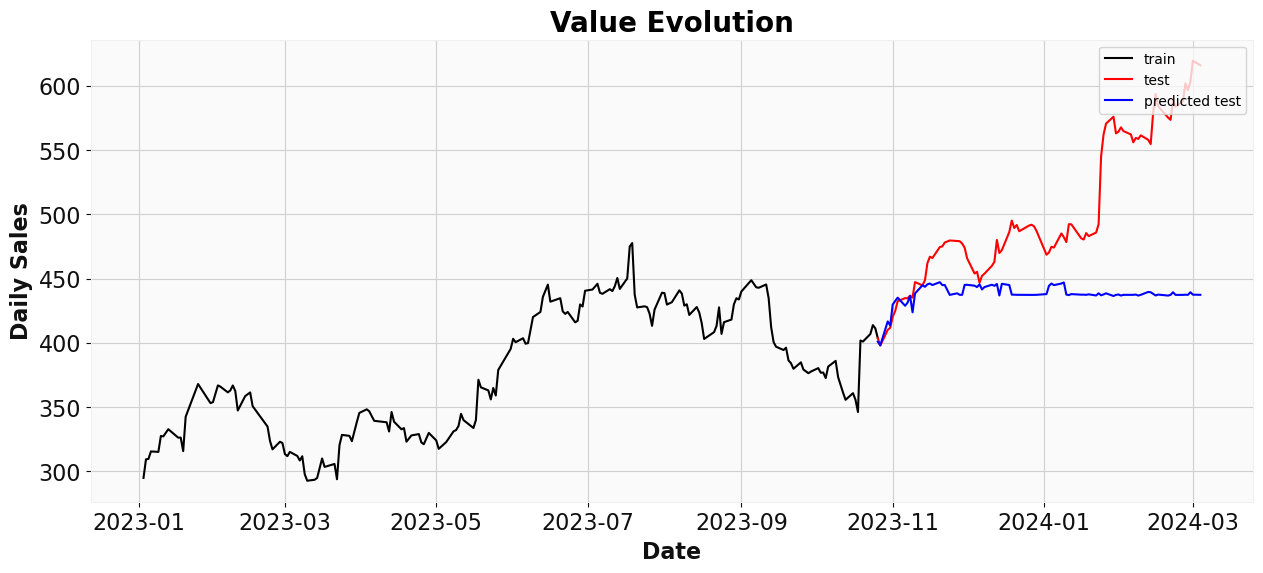

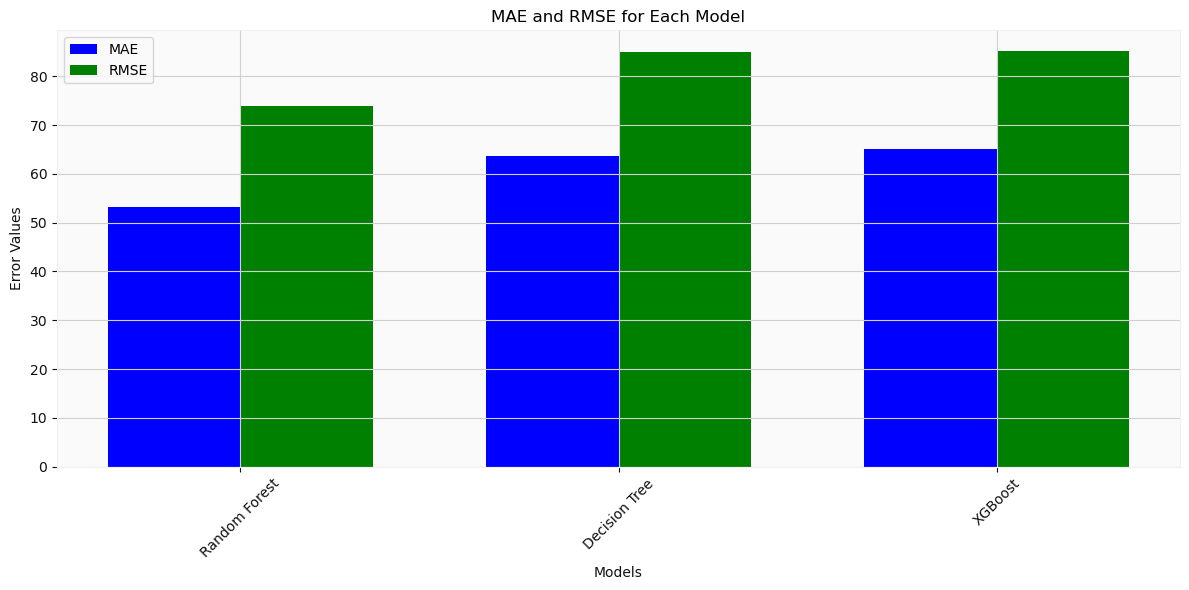

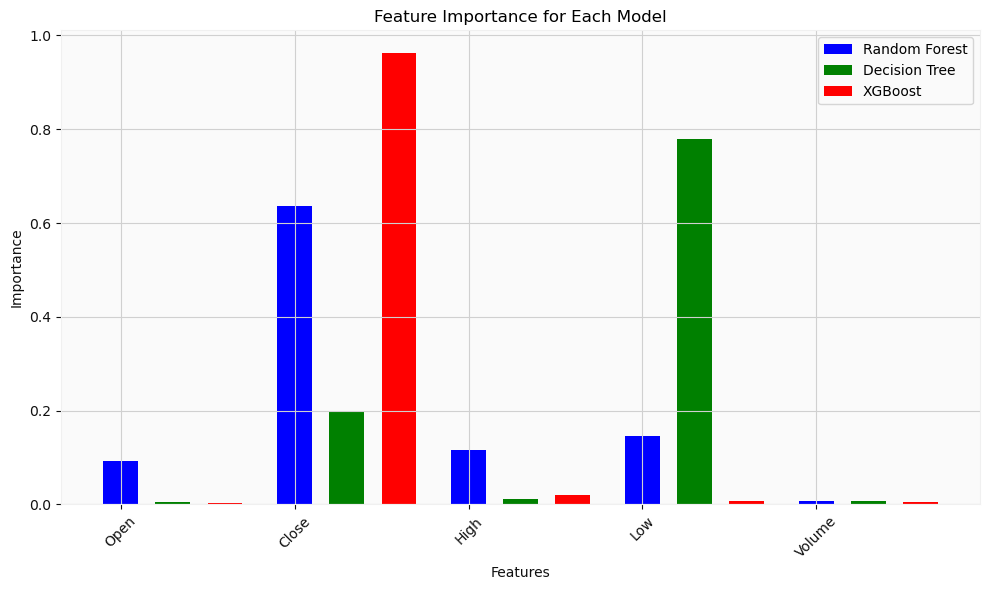

USING SPX500 DATASET
Training and evaluating Random Forest...


/home/marc/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 210.7302050247925
Root Mean squared Error - RMSE : 274.24534199692505
----------------------------------------------------------------------------------------------------


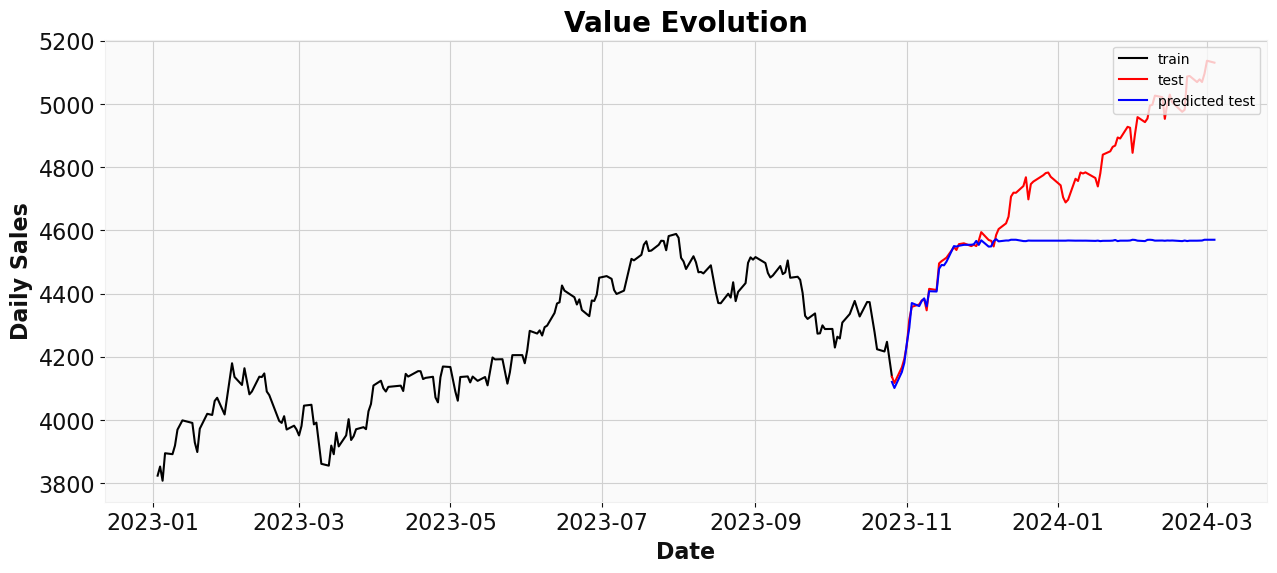

Training and evaluating Decision Tree...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 203.89514193181813
Root Mean squared Error - RMSE : 264.4028200817254
----------------------------------------------------------------------------------------------------


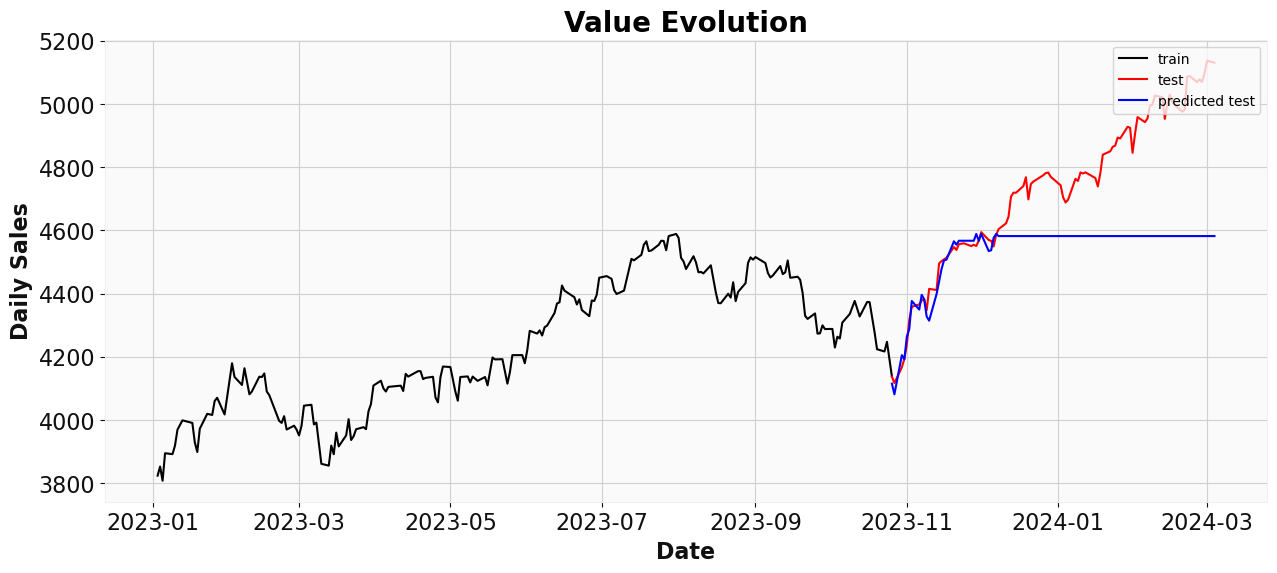

Training and evaluating XGBoost...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 205.77062434019882
Root Mean squared Error - RMSE : 266.5663932323682
----------------------------------------------------------------------------------------------------


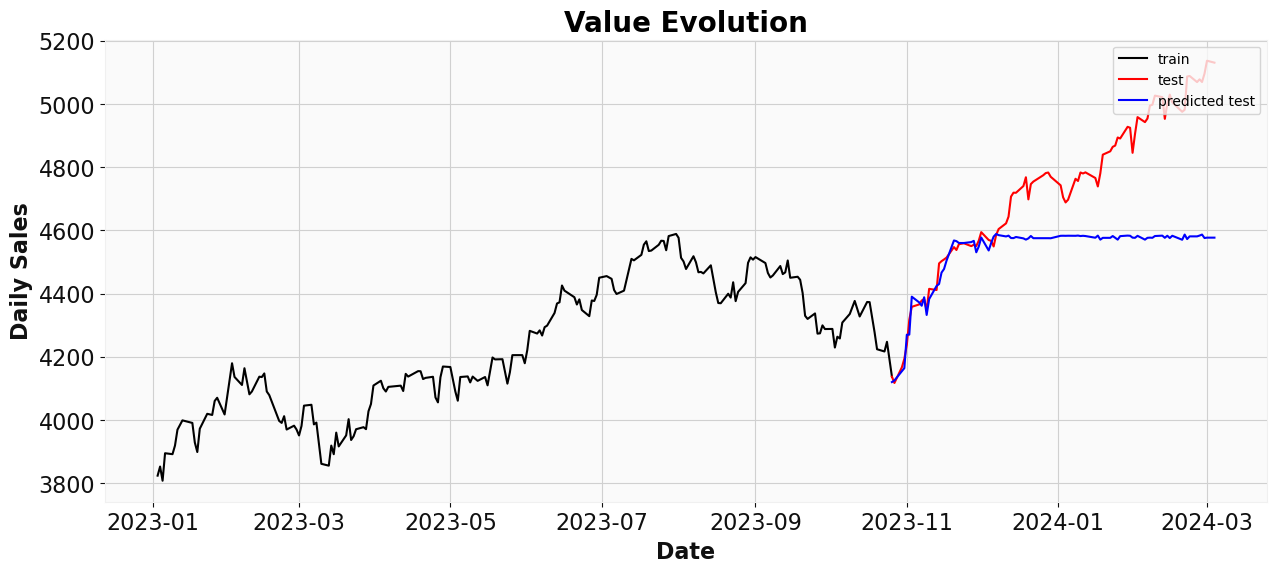

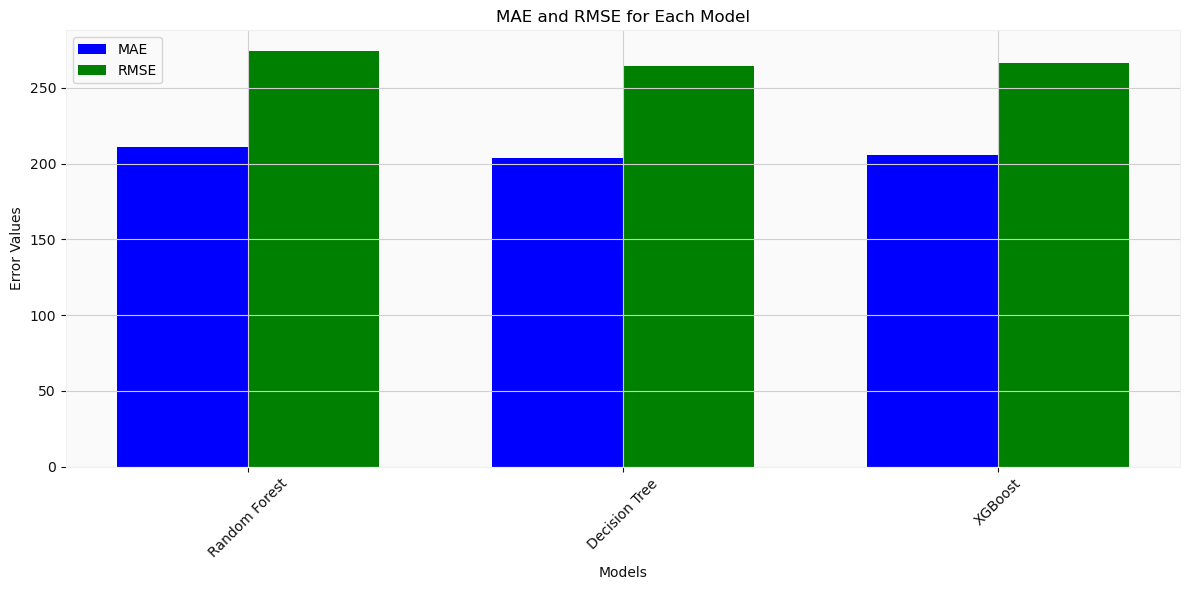

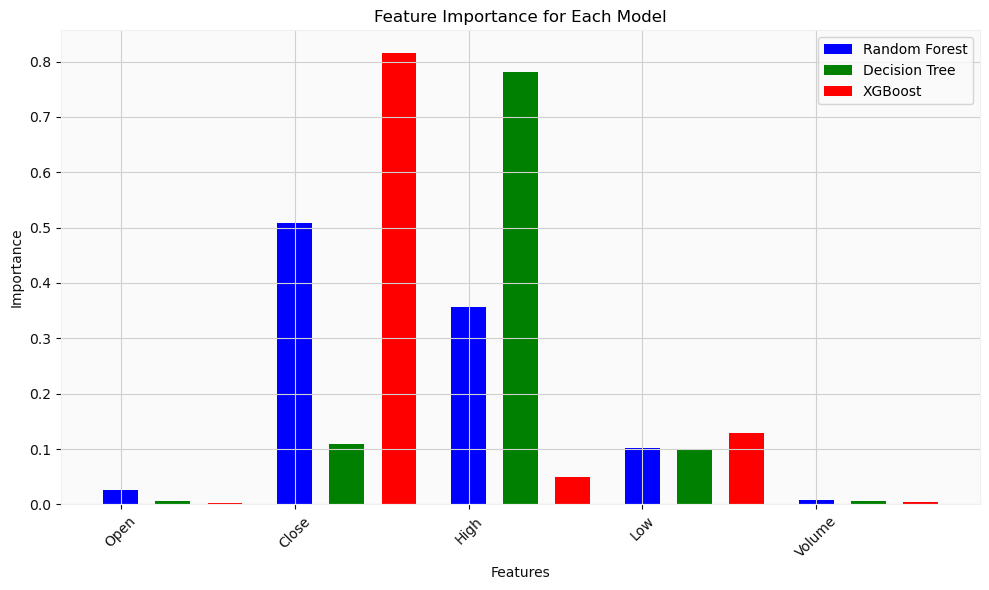

In [30]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=1000),
    "Decision Tree": DecisionTreeRegressor(),
    "XGBoost": XGBRegressor()
}

datasets = {
    "AMAZON": AMAZON2,
    "APPLE": APPLE2,
    "NETFLIX": NETFLIX2,
    "SPX500": SPX5002
}

features = ['Open', 'Close', 'High', 'Low', 'Volume']
target = ['Next Close']

run_regression_models(models, datasets, features, target)

It's clear that Decision Tree, Random Forest, Support Vector Machine, K-Nearest Neighbors and XGBRegression does not predict well the data, so from this poing forward, I am going to descart those models.

Now, from the models that work better let's try to see how it predicts futures values. From this point forward, I'll need a classification model to see how the prices are going to evolve.

### Neuronal Network

Let's try the same but using a different approach. I'm gonna try using neural network models to compare if there're different results.

USING AMAZON DATASET
[STATUS] Training...
[STATUS] Evaluating...
3/3 [==============================] - 0s 4ms/step


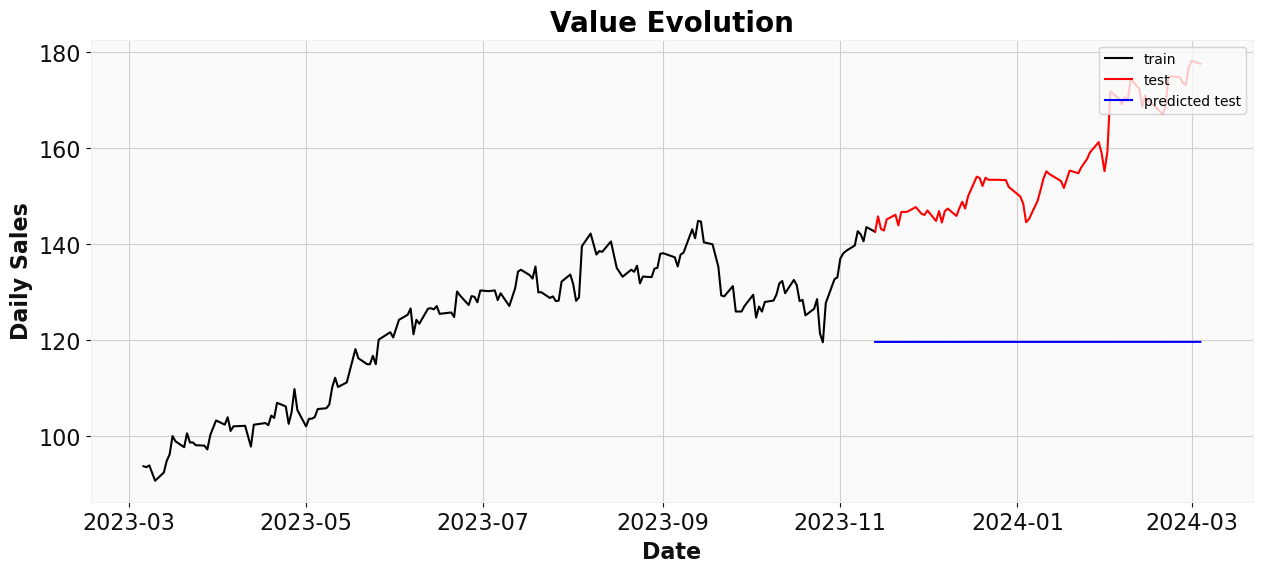

[STATUS] Calculating metrics...
3/3 [==============================] - 0s 4ms/step
USING APPLE DATASET


/home/marc/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/marc/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[STATUS] Training...
[STATUS] Evaluating...
3/3 [==============================] - 0s 5ms/step


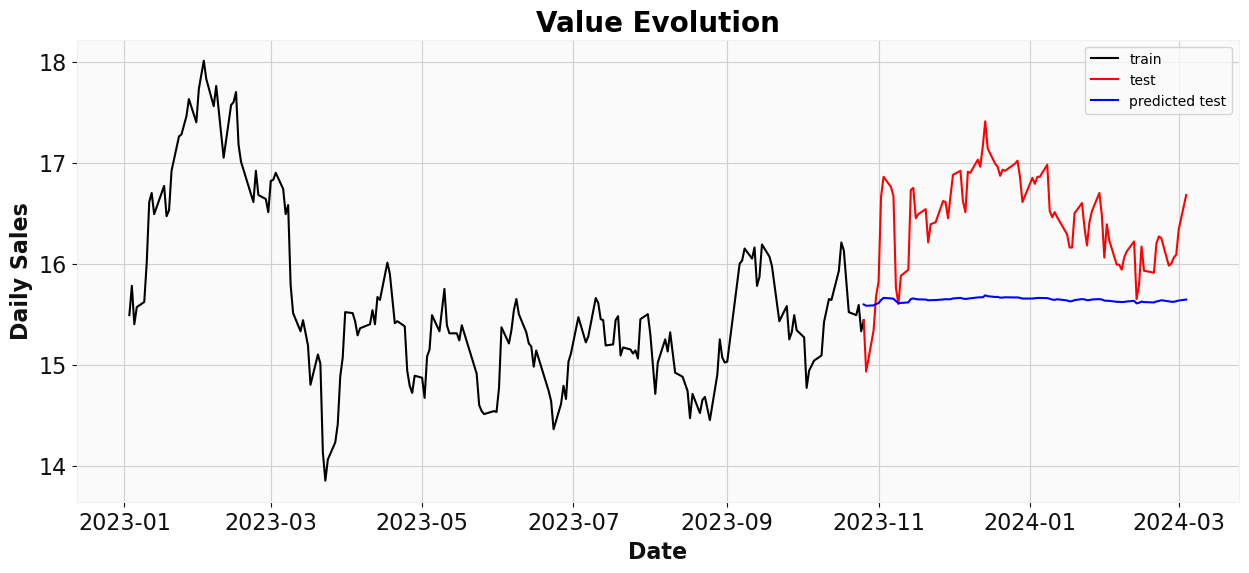

[STATUS] Calculating metrics...
3/3 [==============================] - 0s 4ms/step
USING NETFLIX DATASET


/home/marc/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/marc/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[STATUS] Training...
[STATUS] Evaluating...
3/3 [==============================] - 0s 5ms/step


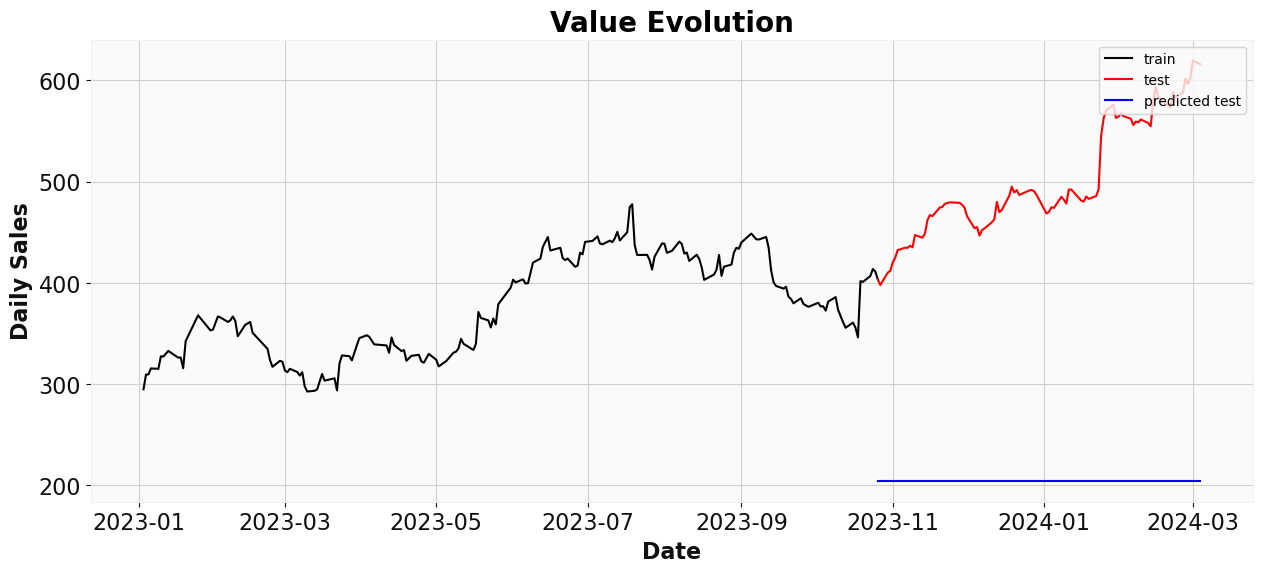

[STATUS] Calculating metrics...
3/3 [==============================] - 0s 4ms/step
USING SPX500 DATASET


/home/marc/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/marc/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[STATUS] Training...
[STATUS] Evaluating...
3/3 [==============================] - 0s 4ms/step


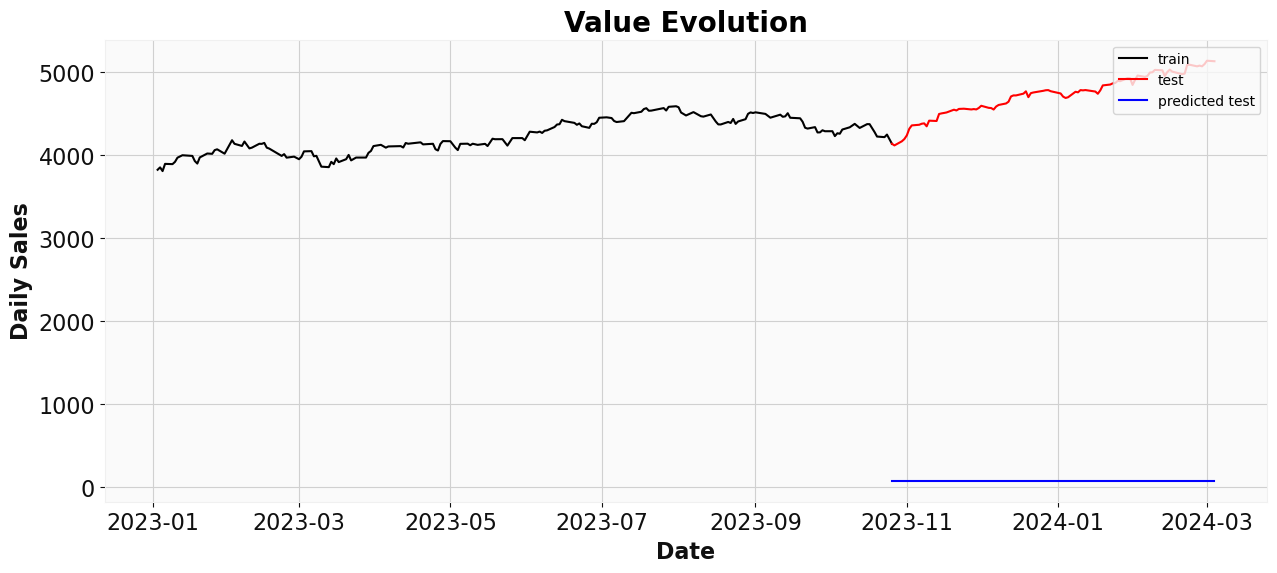

[STATUS] Calculating metrics...
3/3 [==============================] - 0s 4ms/step


/home/marc/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/marc/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


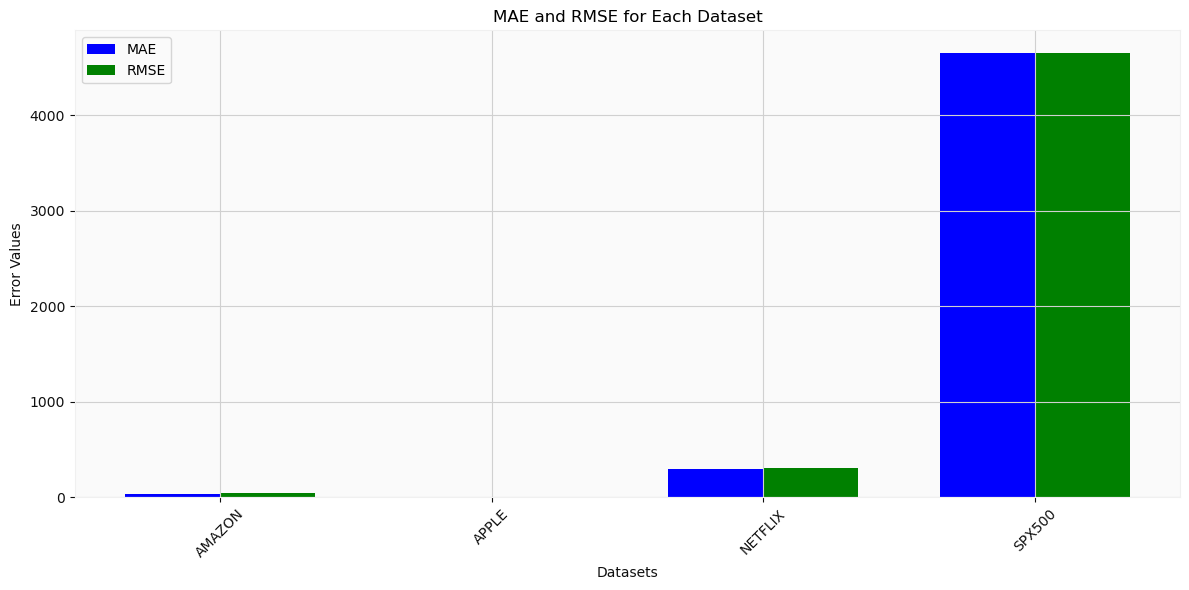

In [31]:
datasets = {
    "AMAZON": AMAZON2,
    "APPLE": APPLE2,
    "NETFLIX": NETFLIX2,
    "SPX500": SPX5002
}

features = ['Open', 'Close', 'High', 'Low', 'Volume']
target = ['Next Close']

run_lstm_model(datasets, features, target)

### Second approach

In this second approach, I'm gonna add the difference between one close and the other one to see if the predictions improve

In [32]:
def add_close_difference(Dataset):
    difference = list()
    difference.append(0)
    
    for i in range(1, len(Dataset.dataset['Close'])):
        diff = Dataset.dataset['Close'][i] - Dataset.dataset['Close'][i-1]
        difference.append(diff)
        
    Dataset.dataset['Difference'] = difference
    return Dataset

In [33]:
AMAZON2 = add_close_difference(AMAZON2); AMAZON2.dataset

Open        High         Low       Close    Volume  \
Date                                                                   
2023-03-06   95.190002   96.550003   93.739998   93.750000  52112400   
2023-03-07   94.059998   95.089996   92.779999   93.550003  49100700   
2023-03-08   93.599998   94.169998   92.180000   93.919998  44899100   
2023-03-09   93.680000   96.209999   92.180000   92.250000  56218700   
2023-03-10   92.669998   93.570000   90.250000   90.730003  69827500   
...                ...         ...         ...         ...       ...   
2024-02-27  174.080002  174.619995  172.860001  173.539993  31141700   
2024-02-28  172.440002  174.050003  172.270004  173.160004  28180500   
2024-02-29  173.009995  177.220001  172.850006  176.759995  53805400   
2024-03-01  176.750000  178.729996  176.070007  178.220001  31956200   
2024-03-04  177.529999  180.139999  177.490005  177.580002  37381500   

            Next Close  Difference  
Date                                
2023-03-06   93.550003    0.000000  
2023-03-07   93.919998   -0.199997  
2023-03-08   92.250000    0.369995  
2023-03-09   90.730003   -1.669998  
2023-03-10   92.430000   -1.519997  
...                ...         ...  
2024-02-27  173.160004   -1.190003  
2024-02-28  176.759995   -0.379989  
2024-02-29  178.220001    3.599991  
2024-03-01  177.580002    1.460006  
2024-03-04  174.119995   -0.639999  

[251 rows x 7 columns]

In [34]:
APPLE2 = add_close_difference(APPLE2); APPLE2.dataset

Open       High        Low      Close   Volume  Next Close  \
Date                                                                          
2023-01-03  15.970000  16.030001  15.380000  15.490000  1335400   15.780000   
2023-01-04  15.720000  16.000000  15.630000  15.780000  1394400   15.400000   
2023-01-05  15.740000  15.740000  15.330000  15.400000  1378800   15.570000   
2023-01-06  15.450000  15.750000  15.450000  15.570000  1232600   15.620000   
2023-01-09  15.540000  15.690000  15.520000  15.620000  1308800   16.010000   
...               ...        ...        ...        ...      ...         ...   
2024-02-27  16.049999  16.139999  15.890000  16.000000  2706200   16.059999   
2024-02-28  15.810000  16.264999  15.790000  16.059999  2470600   16.090000   
2024-02-29  16.209999  16.270000  15.980000  16.090000  2854900   16.340000   
2024-03-01  16.180000  16.430000  16.110001  16.340000  1889900   16.680000   
2024-03-04  16.280001  16.700001  16.270000  16.680000  2642300   16.459999   

            Difference  
Date                    
2023-01-03    0.000000  
2023-01-04    0.290000  
2023-01-05   -0.380000  
2023-01-06    0.170000  
2023-01-09    0.050000  
...                ...  
2024-02-27    0.020000  
2024-02-28    0.059999  
2024-02-29    0.030001  
2024-03-01    0.250000  
2024-03-04    0.340000  

[293 rows x 7 columns]

In [35]:
NETFLIX2 = add_close_difference(NETFLIX2); NETFLIX2.dataset

Open        High         Low       Close   Volume  \
Date                                                                  
2023-01-03  298.059998  298.390015  288.700012  294.950012  6764000   
2023-01-04  298.239990  311.140015  295.510010  309.410004  9345100   
2023-01-05  307.000000  314.179993  304.549988  309.700012  8328400   
2023-01-06  311.570007  316.769989  303.690002  315.549988  8959800   
2023-01-09  316.829987  321.700012  313.220001  315.170013  6766600   
...                ...         ...         ...         ...      ...   
2024-02-27  595.000000  605.359985  592.330017  601.669983  4489400   
2024-02-28  595.789978  598.169983  590.010010  596.479980  2605200   
2024-02-29  604.250000  604.520020  595.159973  602.919983  3572100   
2024-03-01  599.809998  620.280029  599.500000  619.340027  4264200   
2024-03-04  621.559998  624.419983  615.080017  615.830017  3020300   

            Next Close  Difference  
Date                                
2023-01-03  309.410004    0.000000  
2023-01-04  309.700012   14.459992  
2023-01-05  315.549988    0.290008  
2023-01-06  315.170013    5.849976  
2023-01-09  327.540009   -0.379975  
...                ...         ...  
2024-02-27  596.479980   14.019959  
2024-02-28  602.919983   -5.190003  
2024-02-29  619.340027    6.440003  
2024-03-01  615.830017   16.420044  
2024-03-04  598.500000   -3.510010  

[293 rows x 7 columns]

In [36]:
SPX5002 = add_close_difference(SPX5002); SPX5002.dataset

Open         High          Low        Close      Volume  \
Date                                                                         
2023-01-03  3853.290039  3878.459961  3794.330078  3824.139893  3959140000   
2023-01-04  3840.360107  3873.159912  3815.770020  3852.969971  4414080000   
2023-01-05  3839.739990  3839.739990  3802.419922  3808.100098  3893450000   
2023-01-06  3823.370117  3906.189941  3809.560059  3895.080078  3923560000   
2023-01-09  3910.820068  3950.570068  3890.419922  3892.090088  4311770000   
...                 ...          ...          ...          ...         ...   
2024-02-27  5074.600098  5080.689941  5057.290039  5078.180176  3925950000   
2024-02-28  5067.200195  5077.370117  5058.350098  5069.759766  3789370000   
2024-02-29  5085.359863  5104.990234  5061.890137  5096.270020  5219740000   
2024-03-01  5098.509766  5140.330078  5094.160156  5137.080078  4748110000   
2024-03-04  5130.990234  5149.669922  5127.180176  5130.950195  4758440000   

             Next Close  Difference  
Date                                 
2023-01-03  3852.969971    0.000000  
2023-01-04  3808.100098   28.830078  
2023-01-05  3895.080078  -44.869873  
2023-01-06  3892.090088   86.979980  
2023-01-09  3919.250000   -2.989990  
...                 ...         ...  
2024-02-27  5069.759766    8.650391  
2024-02-28  5096.270020   -8.420410  
2024-02-29  5137.080078   26.510254  
2024-03-01  5130.950195   40.810058  
2024-03-04  5078.649902   -6.129883  

[293 rows x 7 columns]

USING AMAZON DATASET
Training and evaluating Random Forest...


/home/marc/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 14.904577936079455
Root Mean squared Error - RMSE : 18.36956500189661
----------------------------------------------------------------------------------------------------


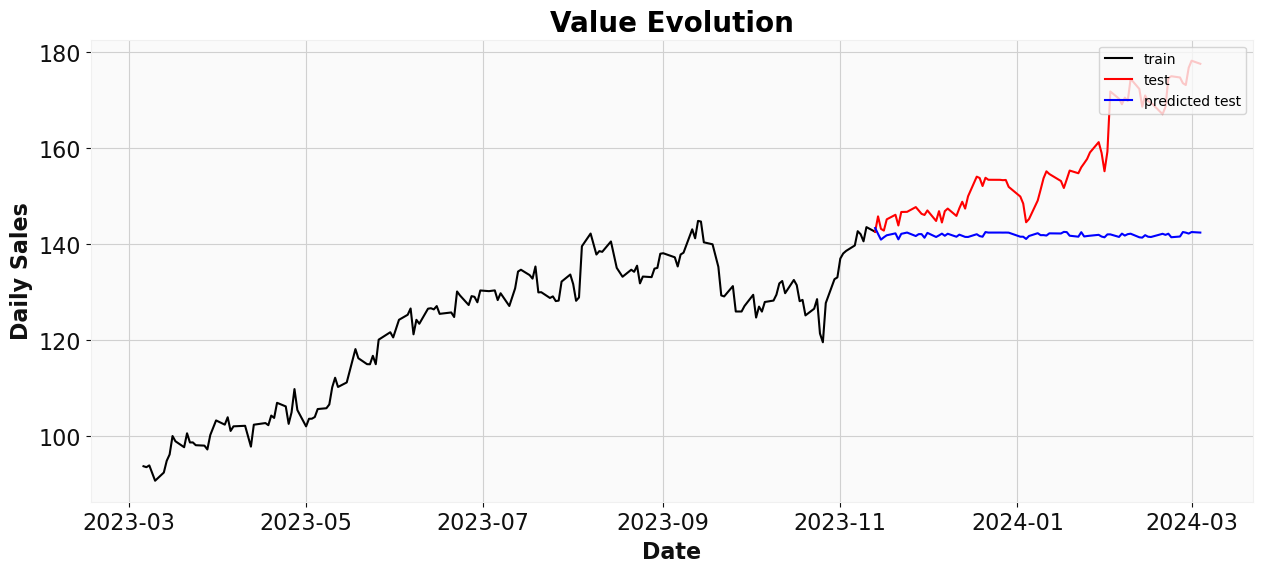

Training and evaluating Decision Tree...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 16.217757907894732
Root Mean squared Error - RMSE : 19.52687467965091
----------------------------------------------------------------------------------------------------


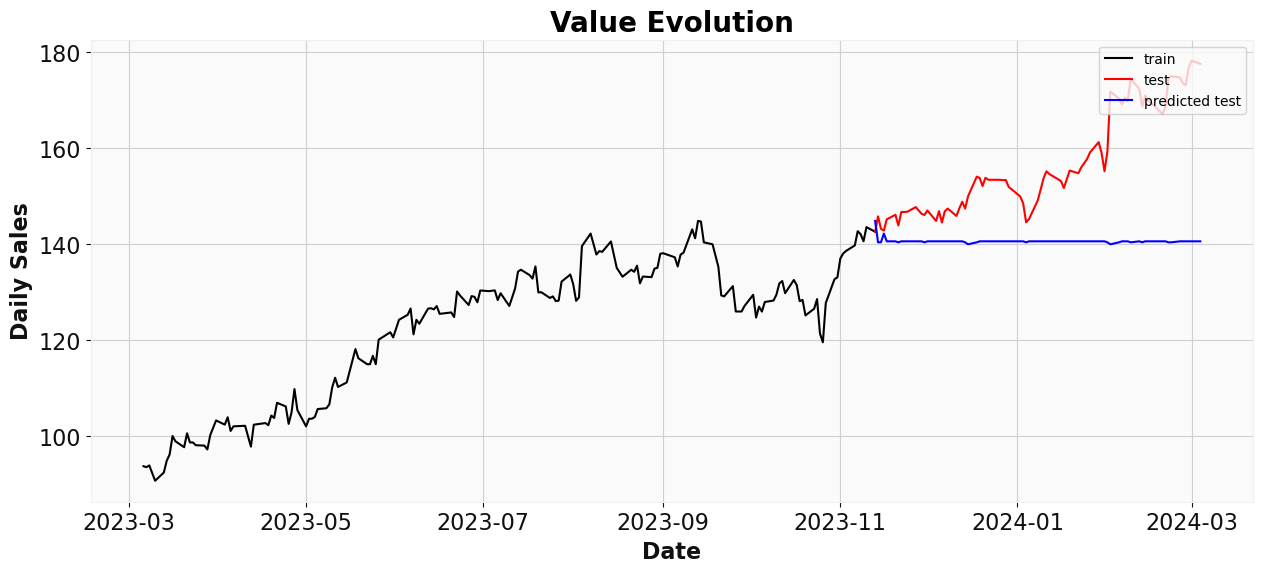

Training and evaluating XGBoost...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 16.124574748265314
Root Mean squared Error - RMSE : 19.459135030930423
----------------------------------------------------------------------------------------------------


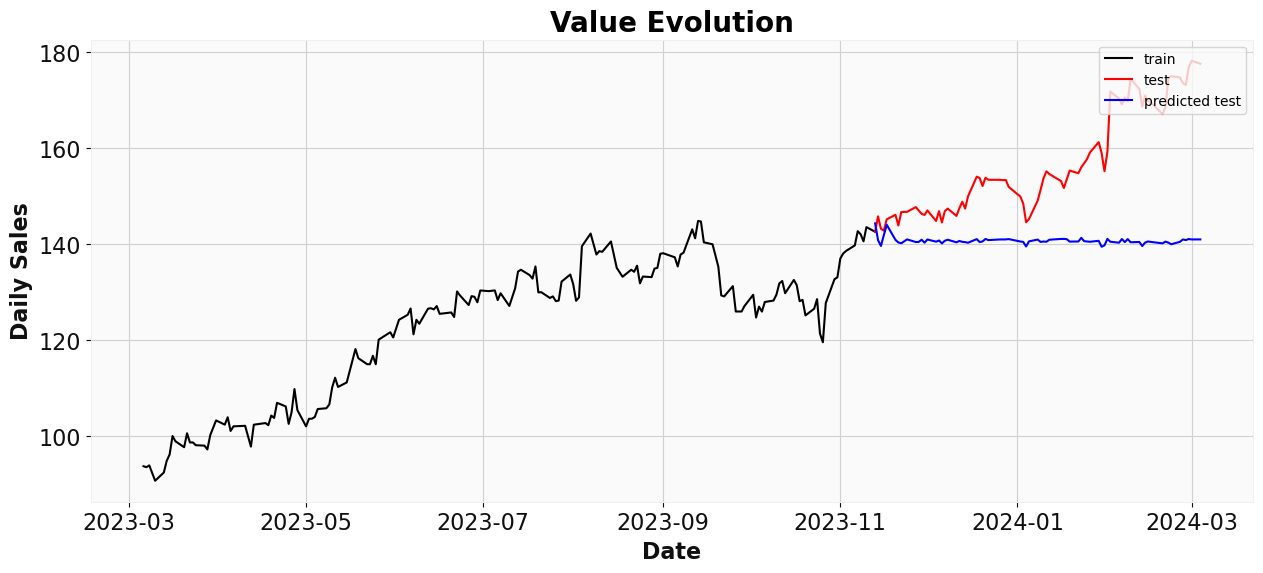

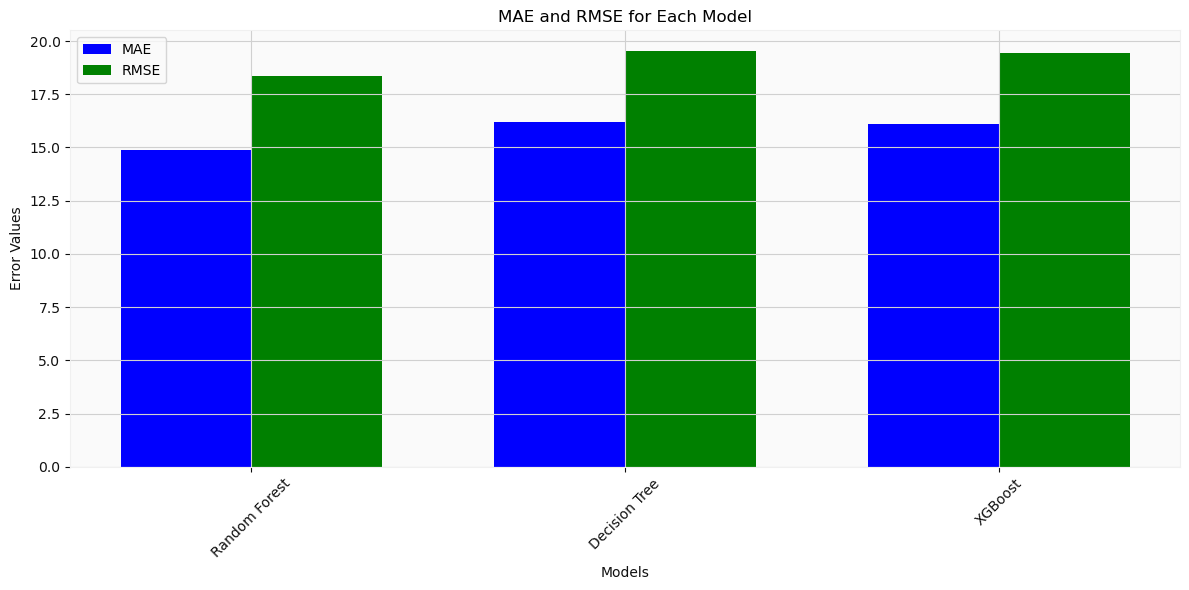

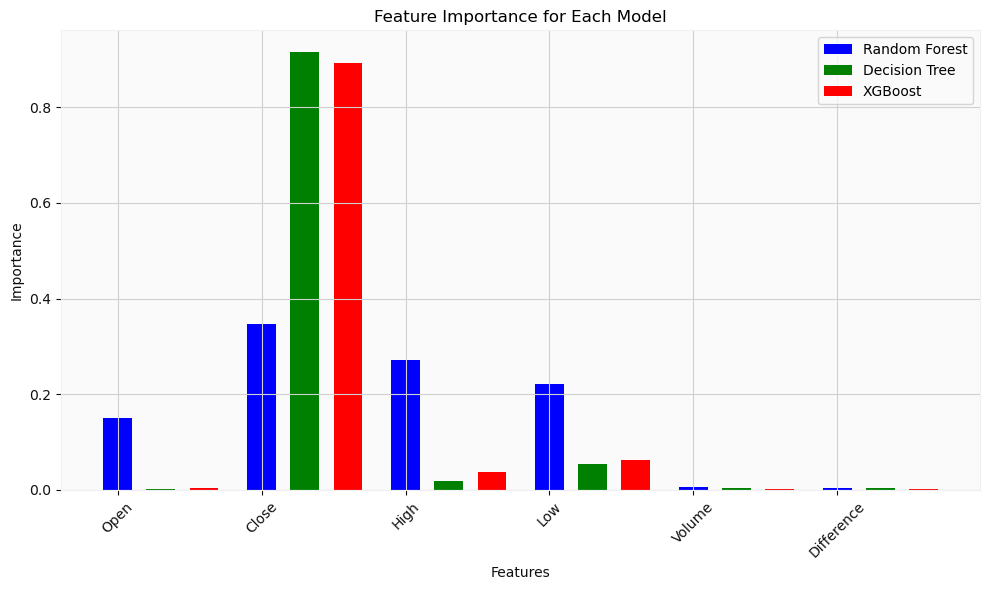

USING APPLE DATASET
Training and evaluating Random Forest...


/home/marc/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 0.22759981514770988
Root Mean squared Error - RMSE : 0.30101630403298435
----------------------------------------------------------------------------------------------------


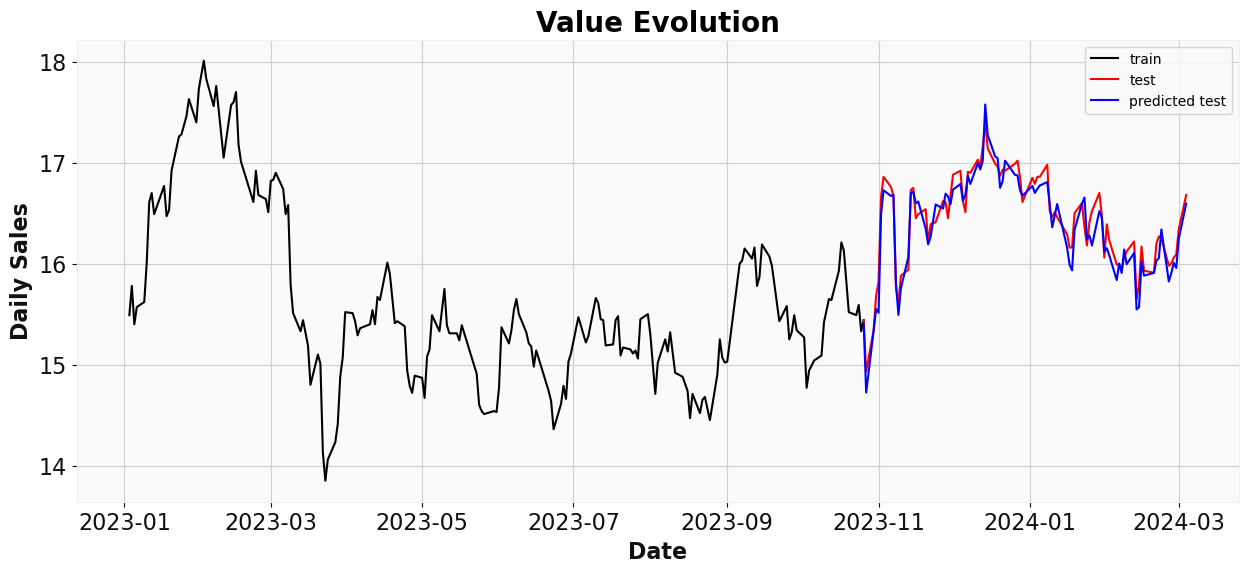

Training and evaluating Decision Tree...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 0.34943187500000006
Root Mean squared Error - RMSE : 0.45554801189018757
----------------------------------------------------------------------------------------------------


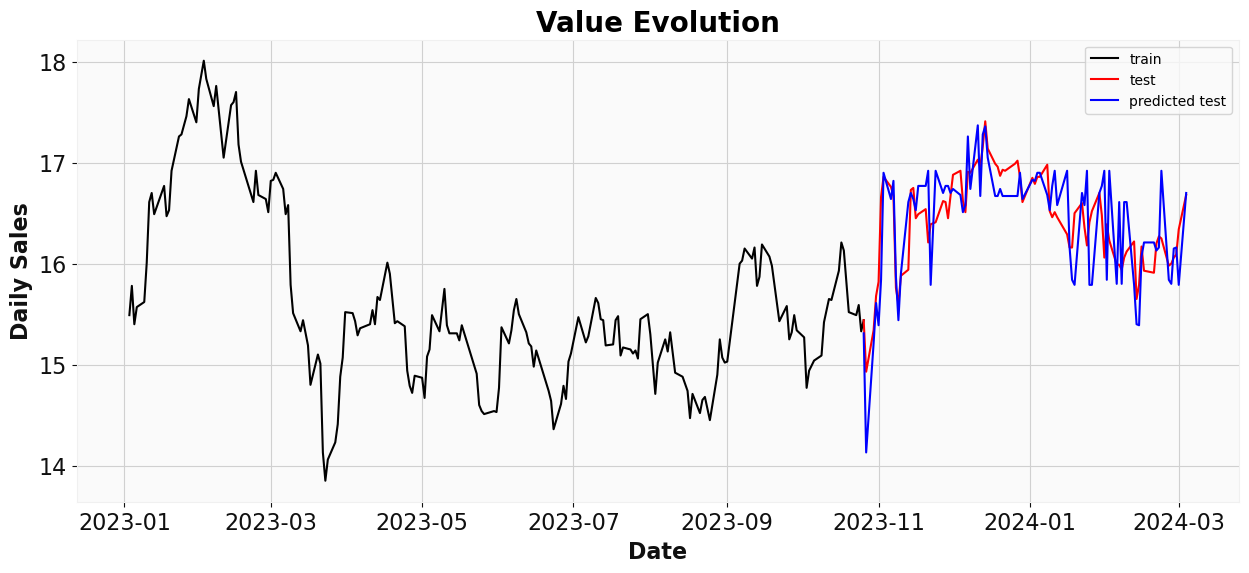

Training and evaluating XGBoost...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 0.25609025252324896
Root Mean squared Error - RMSE : 0.32894869570233215
----------------------------------------------------------------------------------------------------


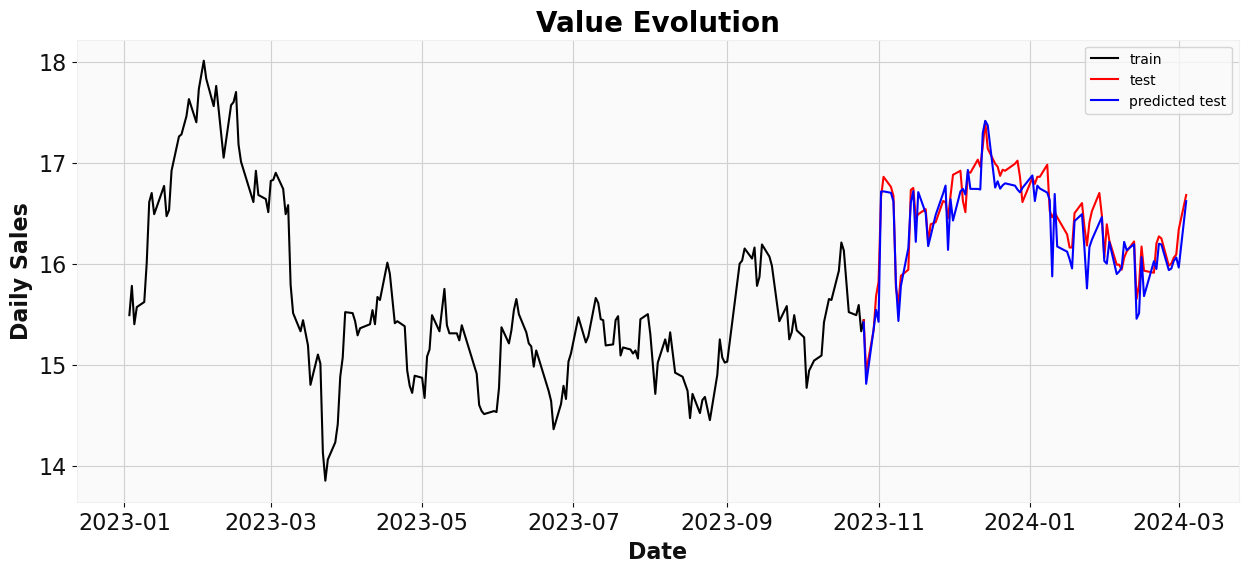

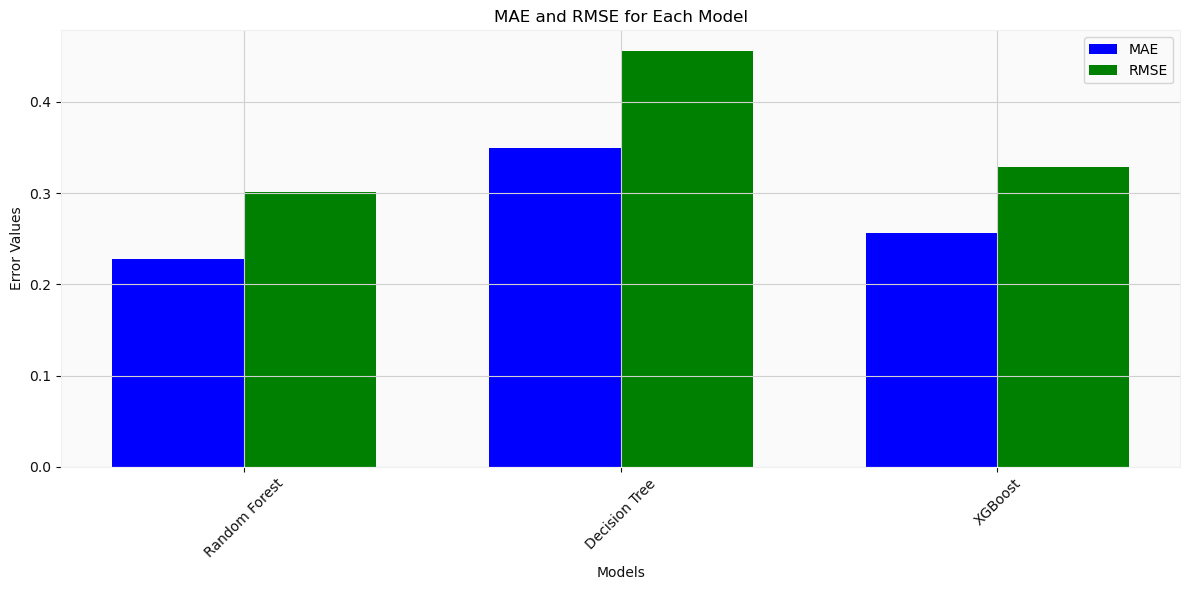

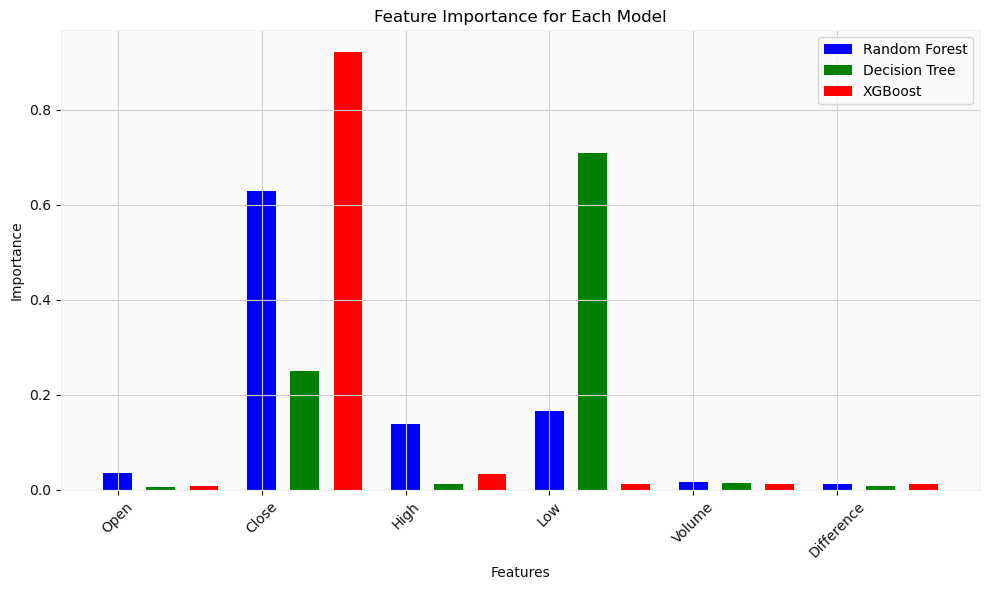

USING NETFLIX DATASET
Training and evaluating Random Forest...


/home/marc/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 53.632685601098316
Root Mean squared Error - RMSE : 73.46841832448236
----------------------------------------------------------------------------------------------------


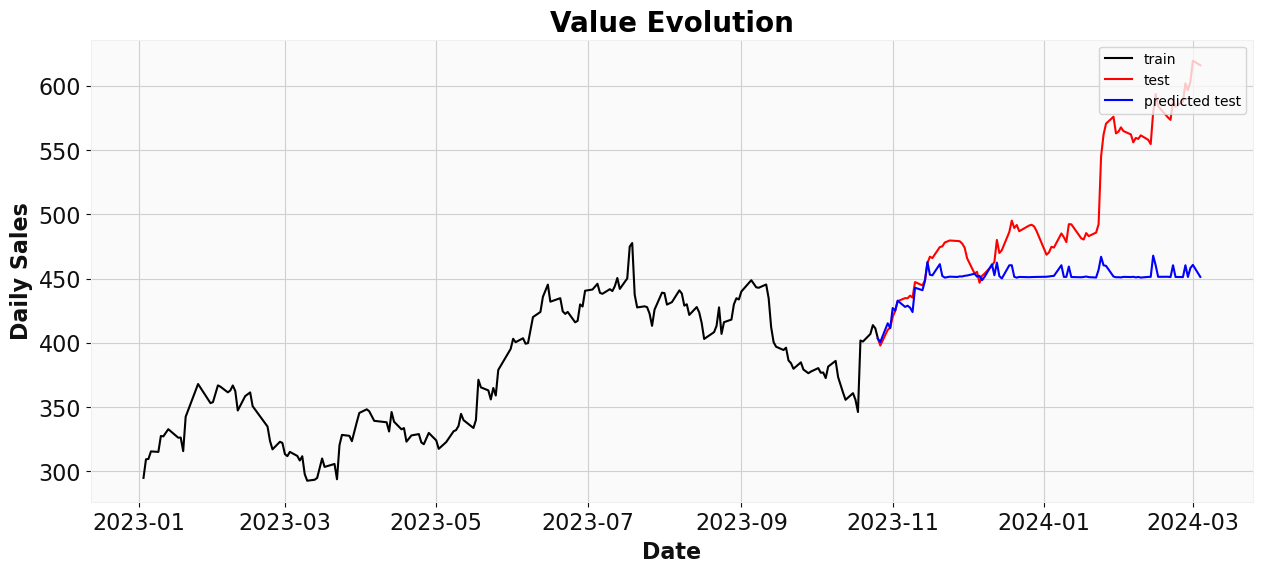

Training and evaluating Decision Tree...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 61.06612946590911
Root Mean squared Error - RMSE : 78.42157536339937
----------------------------------------------------------------------------------------------------


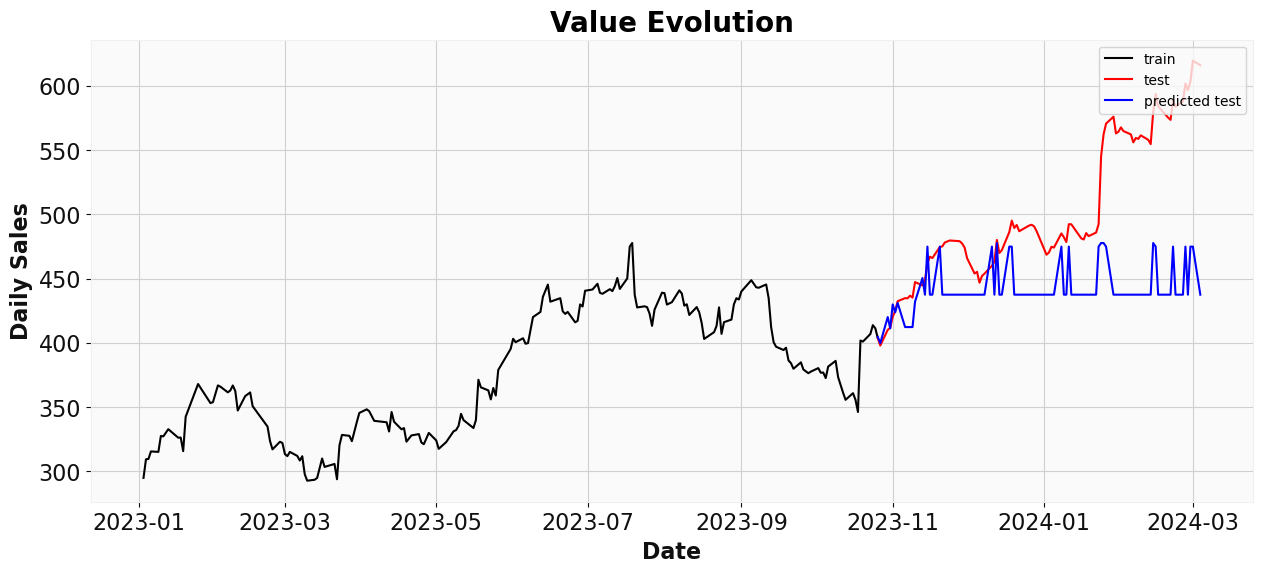

Training and evaluating XGBoost...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 61.975256866077764
Root Mean squared Error - RMSE : 82.9467913425802
----------------------------------------------------------------------------------------------------


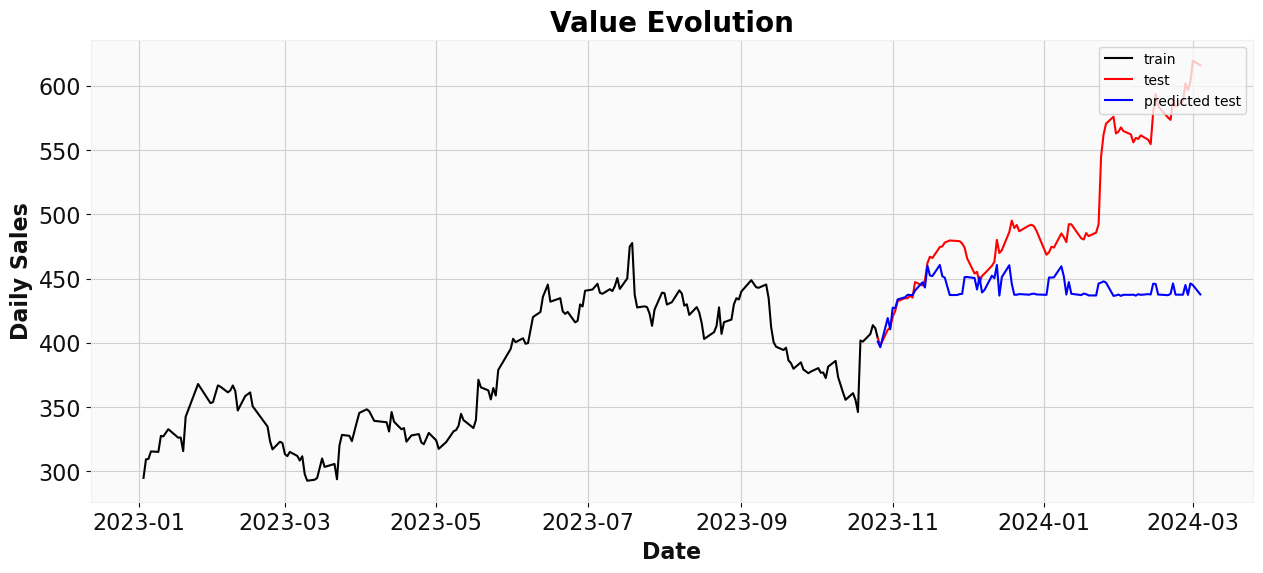

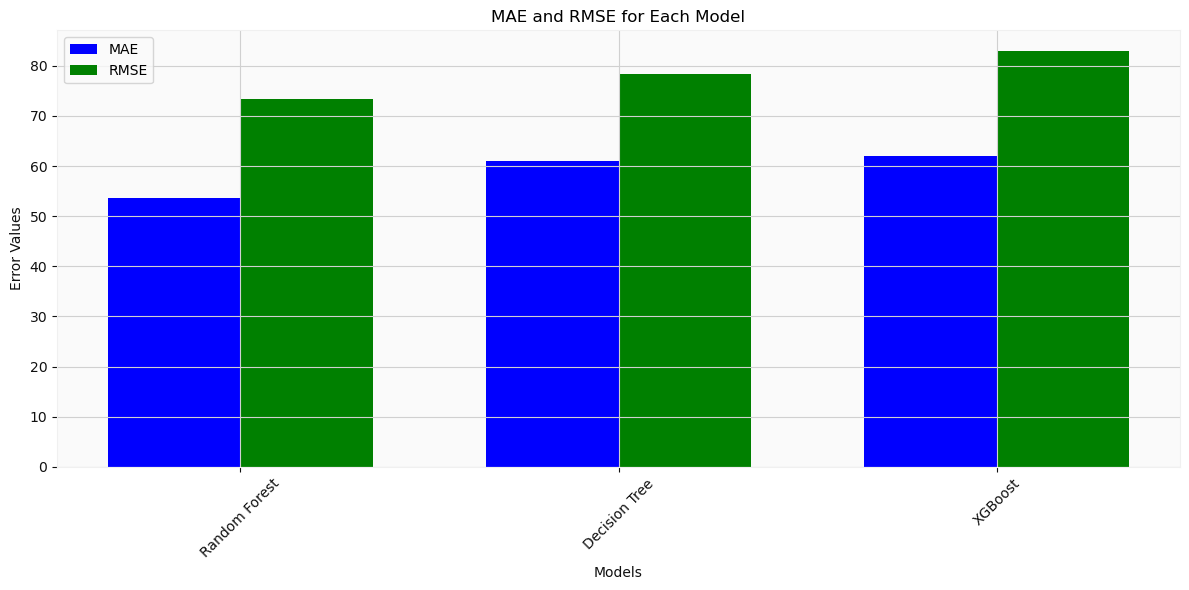

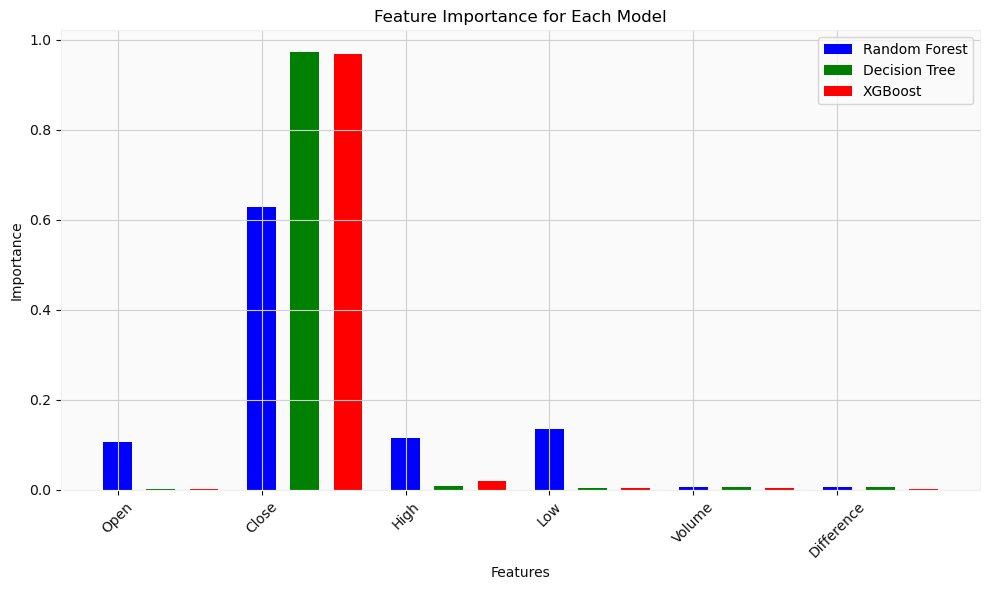

USING SPX500 DATASET
Training and evaluating Random Forest...


/home/marc/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 212.60113908780988
Root Mean squared Error - RMSE : 276.37726392929835
----------------------------------------------------------------------------------------------------


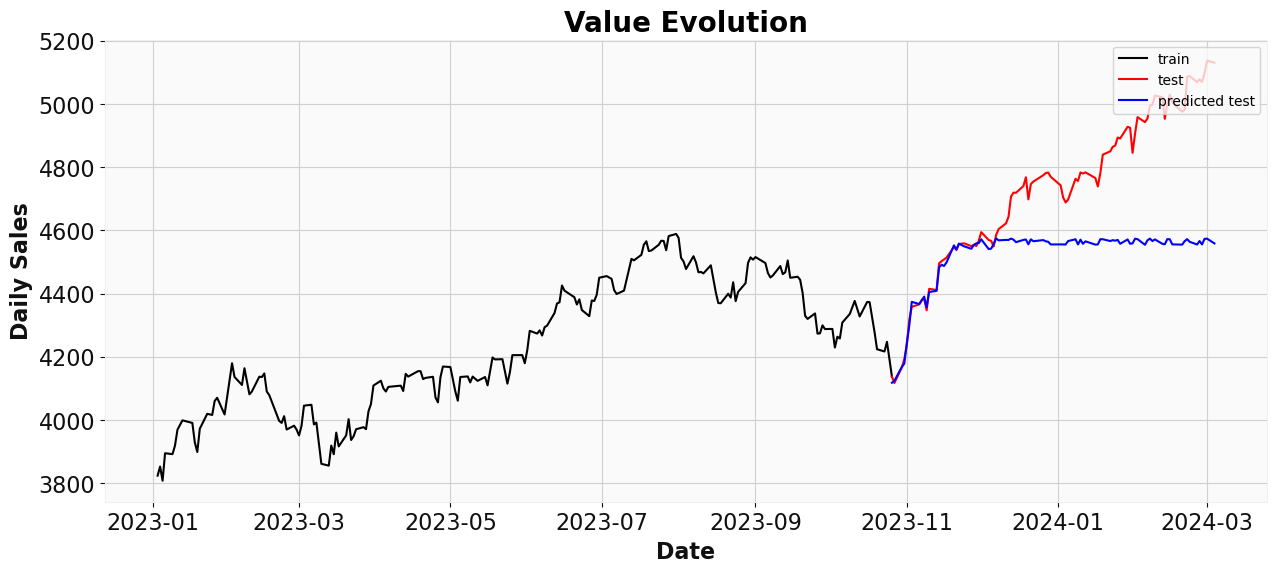

Training and evaluating Decision Tree...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 204.52843160227266
Root Mean squared Error - RMSE : 267.35210039714536
----------------------------------------------------------------------------------------------------


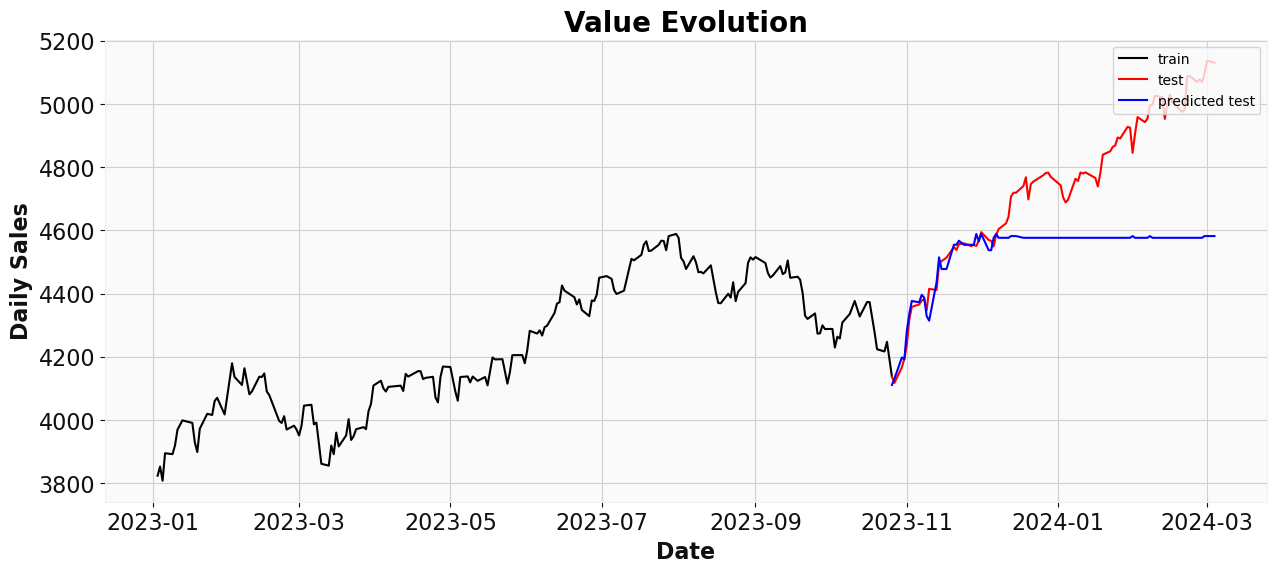

Training and evaluating XGBoost...
----------------------------------------------------------------------------------------------------
Mean Absolute Error - MAE : 210.28022907208805
Root Mean squared Error - RMSE : 272.15974626727916
----------------------------------------------------------------------------------------------------


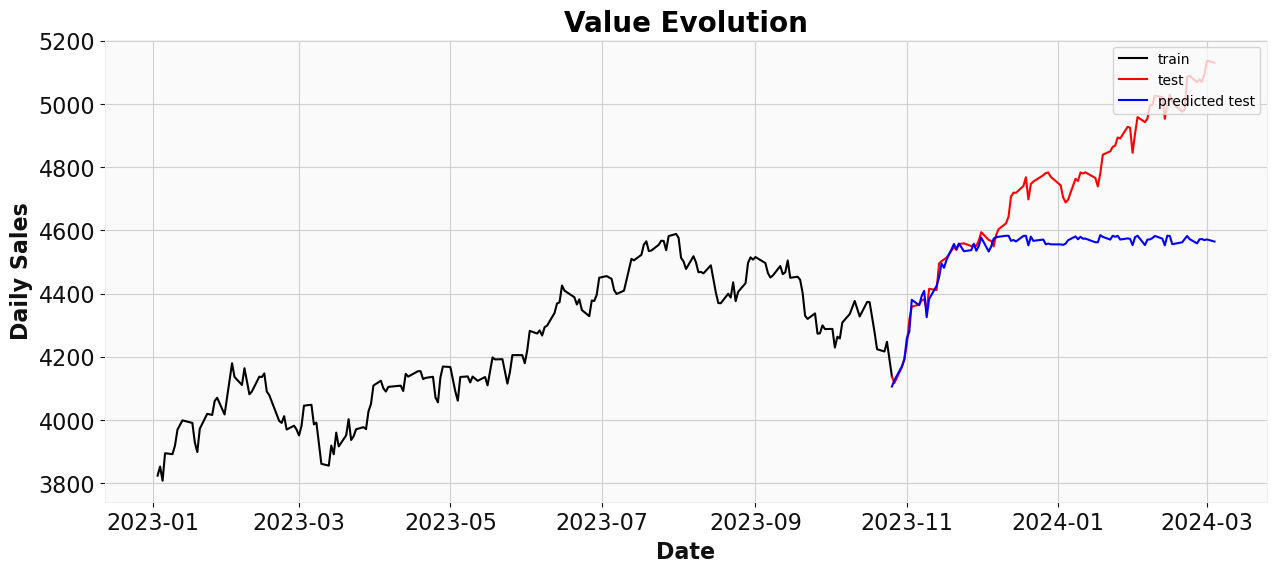

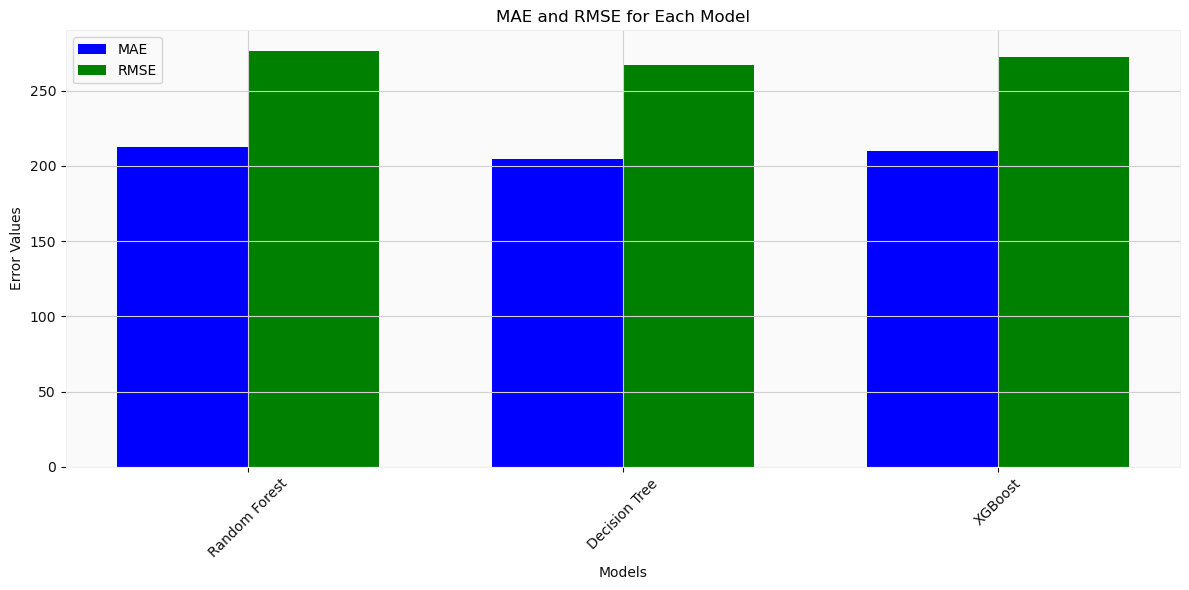

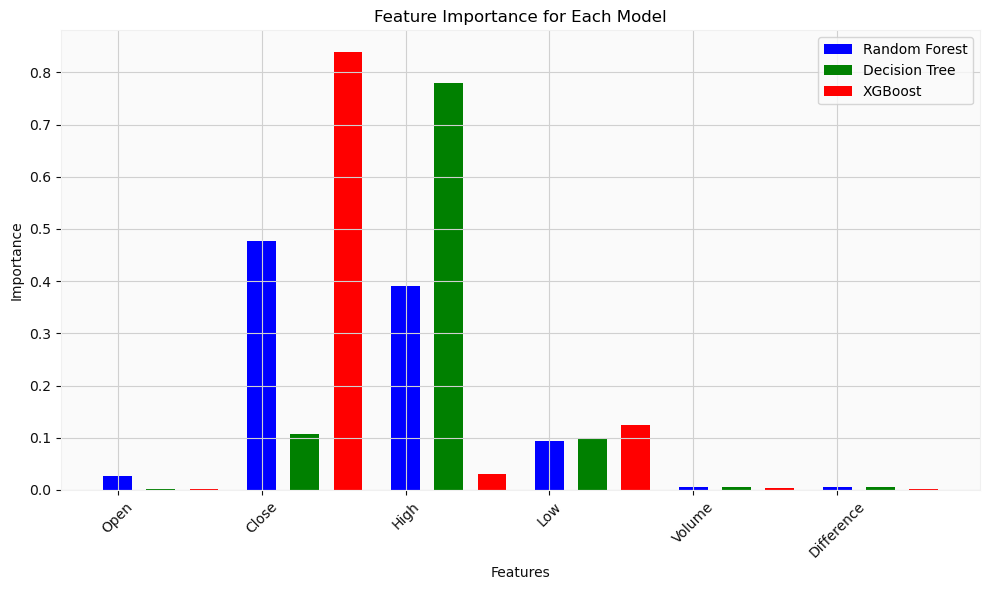

In [37]:
features = ['Open', 'Close', 'High', 'Low', 'Volume', 'Difference']
target = ['Next Close']

run_regression_models(models, datasets, features, target)

USING AMAZON DATASET
[STATUS] Training...
[STATUS] Evaluating...
3/3 [==============================] - 0s 5ms/step


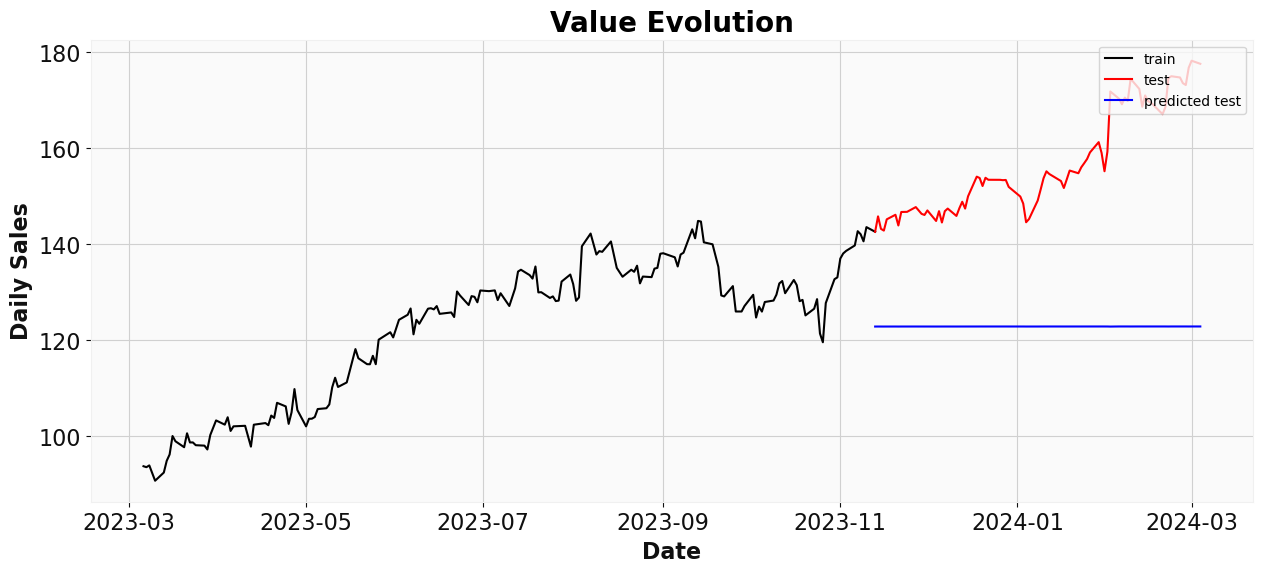

[STATUS] Calculating metrics...
3/3 [==============================] - 0s 4ms/step
USING APPLE DATASET


/home/marc/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/marc/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[STATUS] Training...
[STATUS] Evaluating...
3/3 [==============================] - 0s 5ms/step


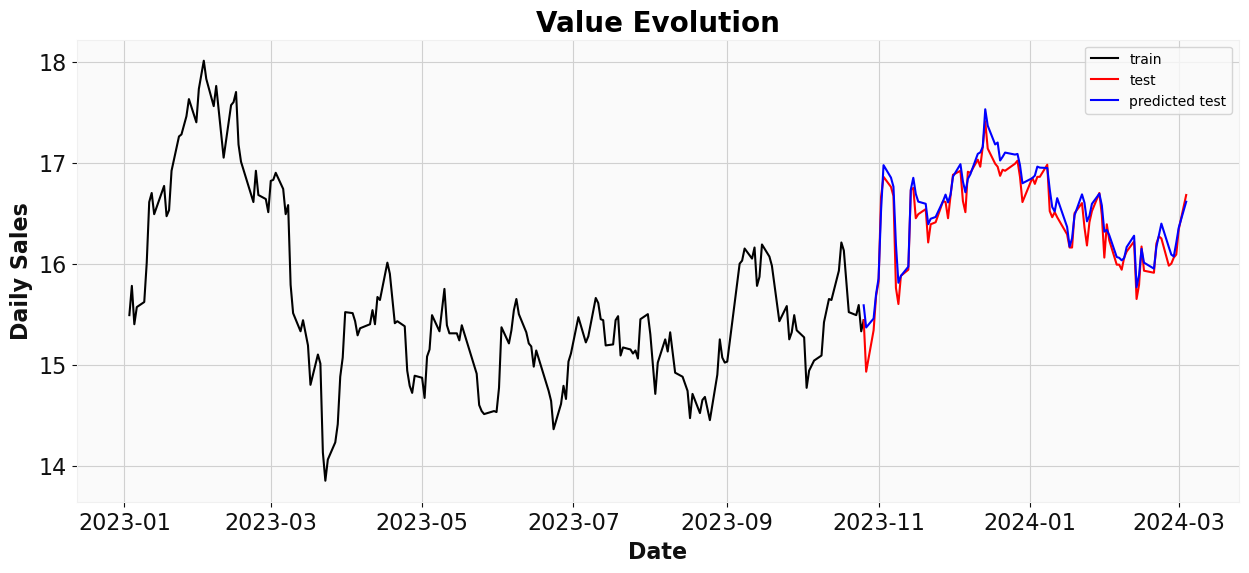

[STATUS] Calculating metrics...
3/3 [==============================] - 0s 5ms/step
USING NETFLIX DATASET


/home/marc/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/marc/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[STATUS] Training...
[STATUS] Evaluating...
3/3 [==============================] - 0s 5ms/step


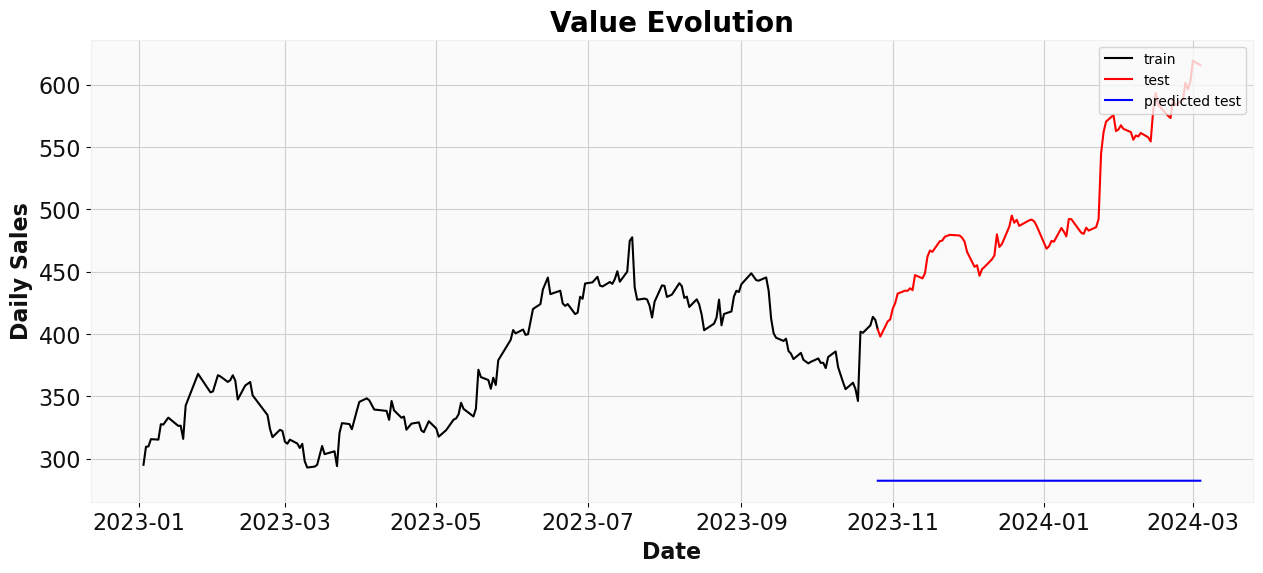

[STATUS] Calculating metrics...
3/3 [==============================] - 0s 5ms/step
USING SPX500 DATASET


/home/marc/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/marc/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[STATUS] Training...
[STATUS] Evaluating...
3/3 [==============================] - 0s 5ms/step


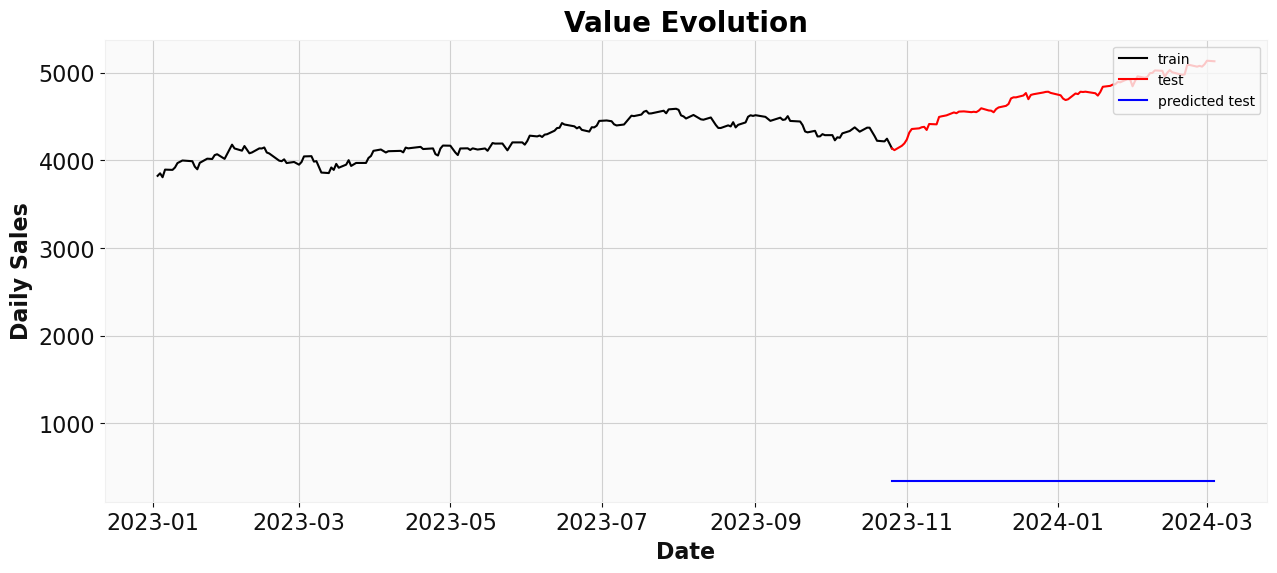

[STATUS] Calculating metrics...
3/3 [==============================] - 0s 5ms/step


/home/marc/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/marc/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


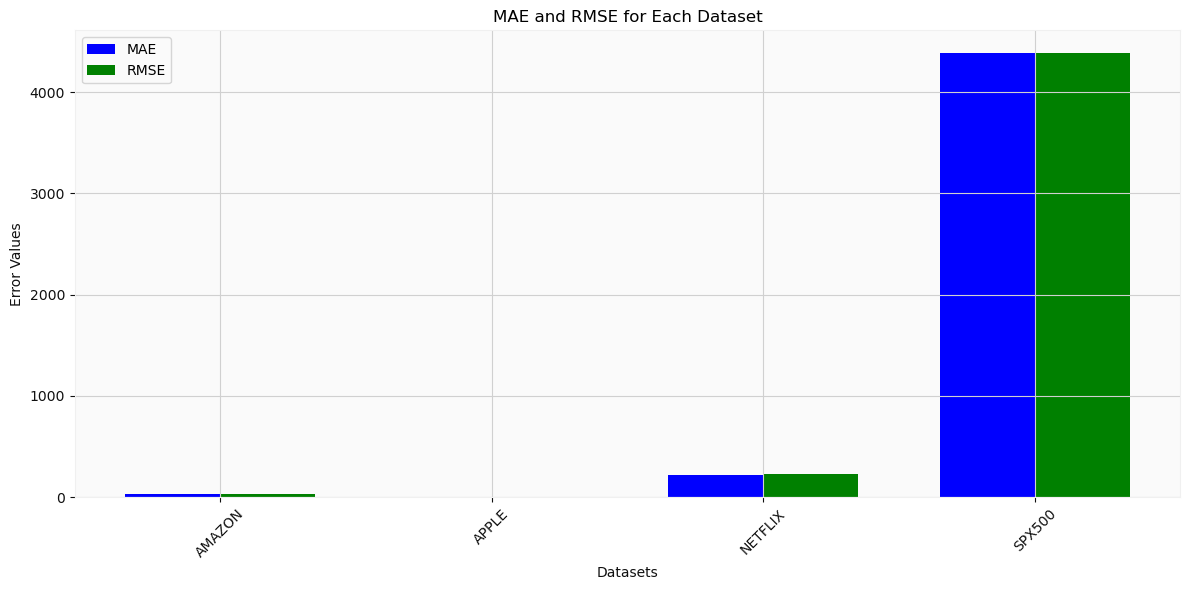

In [38]:
run_lstm_model(datasets, features, target)

### Third approach

We've seen that the volume is never a good a important feature for any model. So, let's try to generate some new variables using that volume, and try to improve those predictions.

In financial analysis, data is mostly representated as a candle, where for each time frame we display the high, low, open and close variables. Below each candle is a barplot where the volume is shown.

Using VSA, we are going to classify each candle for his type, and we are going to analyse if this information is rellevant for futures predictions.

#### No Supply (NS) Candle

A NS candle is one with a smaller volume than the preceding two candles and has a downward movement. It typically signals a price reversal, leading to an upward movement in the following candle.

In [73]:
def mark_no_supply_candles(Dataset):
    ns_list = [False, False]
        
    for index in range(len(Dataset.dataset)):
        if index < 2:  # No cal processar les dues primeres files
            continue
            
        row = Dataset.dataset.iloc[index]
        
        if row['Open'] > row['Close']:
            volume_t_2 = Dataset.dataset.iloc[index-2]['Volume']
            volume_t_1 = Dataset.dataset.iloc[index-1]['Volume']
            volume_t = row['Volume']
            
            if volume_t_2 > volume_t and volume_t_1 > volume_t and volume_t_2 < volume_t_1:
                ns_list.append(True)
            
            else:
                ns_list.append(False)
        
        else:
            ns_list.append(False)
        
        
    Dataset.dataset['NS'] = ns_list
    
    return Dataset     

In [74]:
AMAZON2 = mark_no_supply_candles(AMAZON2); AMAZON2.dataset

Open        High         Low       Close    Volume  \
Date                                                                   
2023-03-06   95.190002   96.550003   93.739998   93.750000  52112400   
2023-03-07   94.059998   95.089996   92.779999   93.550003  49100700   
2023-03-08   93.599998   94.169998   92.180000   93.919998  44899100   
2023-03-09   93.680000   96.209999   92.180000   92.250000  56218700   
2023-03-10   92.669998   93.570000   90.250000   90.730003  69827500   
...                ...         ...         ...         ...       ...   
2024-02-27  174.080002  174.619995  172.860001  173.539993  31141700   
2024-02-28  172.440002  174.050003  172.270004  173.160004  28180500   
2024-02-29  173.009995  177.220001  172.850006  176.759995  53805400   
2024-03-01  176.750000  178.729996  176.070007  178.220001  31956200   
2024-03-04  177.529999  180.139999  177.490005  177.580002  37381500   

            Next Close  Difference     NS  
Date                                       
2023-03-06   93.550003    0.000000  False  
2023-03-07   93.919998   -0.199997  False  
2023-03-08   92.250000    0.369995  False  
2023-03-09   90.730003   -1.669998  False  
2023-03-10   92.430000   -1.519997  False  
...                ...         ...    ...  
2024-02-27  173.160004   -1.190003  False  
2024-02-28  176.759995   -0.379989  False  
2024-02-29  178.220001    3.599991  False  
2024-03-01  177.580002    1.460006  False  
2024-03-04  174.119995   -0.639999  False  

[251 rows x 8 columns]